In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.cluster import kmeans_plusplus
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from annoy import AnnoyIndex
import torchvision
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from torchviz import make_dot
from torchsummary import summary
from IPython.display import Image
device = 'cpu' if torch.backends.mps.is_available() else 'cpu'

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <657200D0-E150-3B86-A0C5-7FD4B7F7C533> /Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Introduction
This notebook implements a simple contrastive learner. Once with a method that picks at random either a positive or a negative image to go with the anchor. 
The other method works by entering a triplet, (anchor, positive, negative). For the second scenario, we have two losses. One works the same way as the first scenrio, by calculating the cosine similarity between the anchor and both the positives and negatives. Then the mse of the cosine losses of both is added and averaged. 
The way the samples were picked originally was by choosing a positive sample as another image from the dataset thats from the same class, and negatives as an image from a different class. Since we want to show cases of self supervised learning, we will have the positives as noise applied to the anchor, and negatives to be simply chosen at random from the dataset.


### Datasets:
- The dataset im using is Mnist
- Two dataset classes, one that returns a pair of anchor and either positive or negative image, second one returns (anchor, positive, negative, pos_label=1.0, neg_label = 0.0)

In [2]:
import cv2

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.

    Args:
        image (np.ndarray): Input image.
        alpha (float): Scaling factor that controls the intensity of the deformation.
        sigma (float): Gaussian filter standard deviation.
        random_state (int): Random seed for reproducibility.

    Returns:
        np.ndarray: Deformed image.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = np.float32(x + dx)
    map_y = np.float32(y + dy)

    return cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)


In [55]:
import torch
import numpy as np
import pandas as pd
from torchvision import transforms, datasets
from torch.utils.data import Dataset

def contrastive_data_loader(dataset='mnist', class_labels_list=[0, 1], num_samples=1, normalise_data=True, isImg=True, noise_level=0.1, contrastive=True, use_class_sampling=False, elastic=True):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])
    
    if dataset == 'mnist':
        # Load the MNIST dataset
        data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        print('MNIST loaded dataset', data)
        X_full = data.data.view(data.data.size(0), -1).float() / 255  # Normalize the data
        Y_full = data.targets
        x_idx = torch.tensor([]).long()
        
        # select only items from class_label
        for i in class_labels_list:
            x_idx = torch.cat((x_idx, (Y_full == i).nonzero(as_tuple=True)[0]))
            
        # randomise and cut indices
        shuffled = torch.randperm(x_idx.size(0))[:num_samples]
        indices = x_idx[shuffled]
        X = X_full[indices]
        Y = Y_full[indices]
        
        # Create a DataFrame from the selected data
        data_df = pd.DataFrame(X.numpy())
        data_df.insert(0, 'label', Y.numpy())
    return AugmentedMNISTDataset(data_df, transform=transform, contrastive=contrastive, noise_level=noise_level, use_class_sampling=use_class_sampling, elastic=elastic), X, Y

class AugmentedMNISTDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, clust_assign=None, transform=None, contrastive=True, noise_level=0.1, use_class_sampling=False, elastic=True):
        super(AugmentedMNISTDataset, self).__init__()
        self.data_df = data_df
        self.clust_assign = clust_assign
        self.transform = transform
        self.elastic_transform = elastic_transform
        self.contrastive = contrastive
        self.use_class_sampling = use_class_sampling
        self.elastic = elastic
        
    def __len__(self):
        return len(self.data_df)

    def set_clust_assign(self, clust_assign):
        self.clust_assign = clust_assign

    def __getitem__(self, idx):
        anchor_data = self.data_df.iloc[idx].to_numpy()
        anchor_image = anchor_data[1:].reshape(28, 28).astype(np.float32)
        label = anchor_data[0]

        if self.use_class_sampling:
            # Positive sample: another image from the same class
            positive_idx = idx
            while positive_idx == idx:
                positive_idx = np.random.choice(self.data_df[self.data_df['label'] == label].index)
            positive_data = self.data_df.loc[positive_idx].to_numpy()
            positive_image = positive_data[1:].reshape(28, 28).astype(np.float32)
            
            # Negative sample: pick a random image from a different cluster based on clust_assign
            negative_idx = idx
            anchor_cluster = torch.argmax(self.clust_assign[:, idx]).item()
            while negative_idx == idx or torch.argmax(self.clust_assign[:, negative_idx]).item() == anchor_cluster:
                negative_idx = np.random.randint(0, len(self.data_df))
            negative_data = self.data_df.iloc[negative_idx].to_numpy()
            negative_image = negative_data[1:].reshape(28, 28).astype(np.float32)
        else:
            anchor_cluster = torch.argmax(self.clust_assign[:, idx]).item()
            if self.elastic:
                # Positive sample: apply elastic transformation to the same image
                positive_image = self.elastic_transform(anchor_image, alpha=42, sigma=5)
            else:
                positive_idx = idx
                while positive_idx == idx or torch.argmax(self.clust_assign[:, positive_idx]).item() != anchor_cluster:
                    positive_idx = np.random.randint(0, len(self.data_df))
                positive_data = self.data_df.iloc[positive_idx].to_numpy()
                positive_image = positive_data[1:].reshape(28, 28).astype(np.float32)

            # Negative sample: pick a random different image
            negative_idx = idx
            while negative_idx == idx or torch.argmax(self.clust_assign[:, negative_idx]).item() == anchor_cluster:
                negative_idx = np.random.randint(0, len(self.data_df))
            negative_data = self.data_df.iloc[negative_idx].to_numpy()
            negative_image = negative_data[1:].reshape(28, 28).astype(np.float32)

        if self.transform is not None:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        if np.random.randint(0, 2) == 0:
            second = positive_image
            similarity = 1.0
        else:
            second = negative_image
            similarity = 0.0
        
        if self.contrastive:
            return idx, anchor_image, positive_image, negative_image, 1.0, 0.0, label
        else:
            return idx, anchor_image, second, similarity, label


In [184]:
def plot_dataset_sample(dataset, index, contrastive):

    if contrastive:
        idx, first, second, third, second_label, third_label, label = dataset[index]
        third = third.numpy().transpose((1, 2, 0))

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    else:
    # Get the sample from the dataset
        idx, first, second, second_label, label = dataset[index]
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Convert tensors to numpy arrays for plotting
    first_img = first.numpy().transpose((1, 2, 0))
    second_img = second.numpy().transpose((1, 2, 0)) 

    # Plot the first image
    axes[0].imshow(first_img.squeeze(), cmap='gray')
    axes[0].set_title(f'Anchor')
    axes[0].axis('off')

    # Plot the second image
    axes[1].imshow(second_img.squeeze(), cmap='gray')
    axes[1].set_title(f'Positve Augmentation')
    axes[1].axis('off')
    # Plot the third image
    if contrastive:
        axes[2].imshow(third.squeeze(), cmap='gray')
        axes[2].set_title(f'Negative sample')
        axes[2].axis('off')

    plt.show()

#### Networks:
The network is a simple convolutional model. 

In [57]:
class Network(nn.Module):
    # Expects a 28x28 image, returns a flat embed
    def __init__(self, embed=64):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        ) # d * 32 * 12 * 12
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        ) # d * 64 * 4 * 4
        self.linear1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, embed),
        )

    def forward(self, x):
        x = self.conv1(x) # x: d * 32 * 12 * 12
        x = self.conv2(x) # x: d * 64 * 4  * 4 
        x = x.view(x.size(0), -1) # x: d * (64*4*4)
        x = self.linear1(x) # x: d * 64
        return x

def visualize_network(net):
    x = torch.randn(1, 1, 28, 28)  # Dummy input tensor
    y = net(x)  # Forward pass to create the computation graph
    graph = make_dot(y, params=dict(list(net.named_parameters()) + [('x', x)]))
    return graph

def summarize_model(model, input_size):
    summary(model, input_size)

# Example usage
model_summary = Network(embed=64)
summarize_model(model_summary, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
           Dropout-5           [-1, 32, 12, 12]               0
            Conv2d-6             [-1, 64, 8, 8]          51,264
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Dropout-10             [-1, 64, 4, 4]               0
           Linear-11                  [-1, 512]         524,800
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [58]:
# Example usage
net = Network()
graph = visualize_network(net)
graph.render("network_visualization", format="png")

'network_visualization.png'

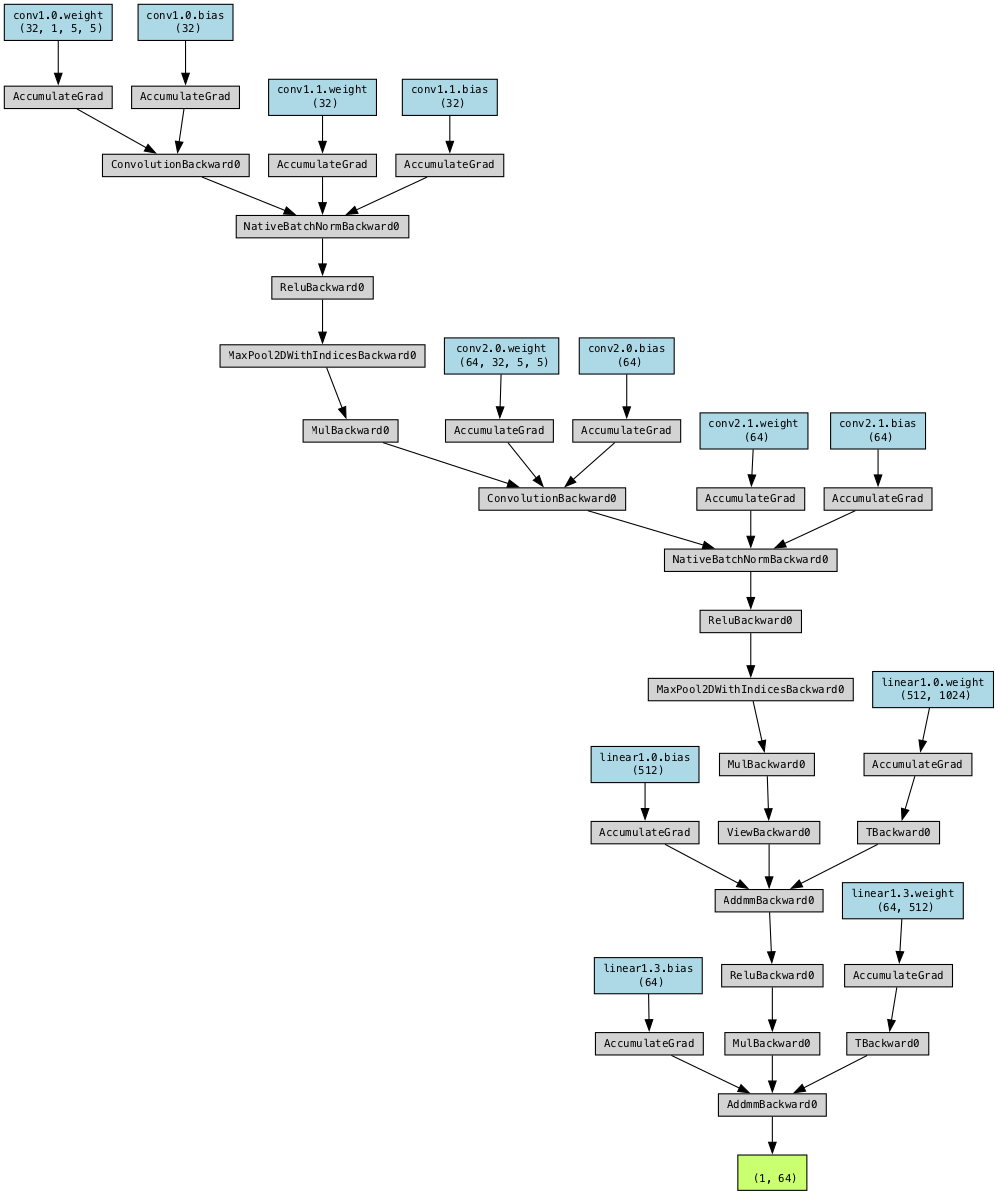

In [59]:
Image(filename="network_visualization.png")


#### Losses:
- CosineLoss: gets the cosine similarity between the anchor and the secon image (Whether positive or negative), returns the mse between the real distance (label, 1.0 if positive, 0.0 if negative).
- ContrastiveLoss: defines the Contrastive Kernel Learning loss from the paper https://arxiv.org/pdf/2309.02028 

In [60]:
class CosineLoss(nn.Module):
    # Input: [batch_size, embed]
    # Output: [batch_size]
    def __init__(self):
        super(CosineLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, first, second, distance):
        score = self.similarity(first, second)
        individual_losses = (score - distance) ** 2
        return individual_losses.float()


In [61]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()

    def forward(self, anchors, positives, negatives):
        # Calculate (u(x^-) - u(x^+)) for all examples in the batch
        diff = negatives - positives
        # Anchor shape: [batch_size, embedding_size]
        # Calculate u(x).T * (u(x^-) - u(x^+)) for all examples in the batch
        # Resulting shape: [batch_size]
        loss_per_example = torch.sum(anchors * diff, dim=-1)
        # batch_loss = torch.mean(avg_anchor_losses) + (0.00001 * torch.square(torch.norm(anchors)))
        return loss_per_example

#### Functions for the tensorization

In [62]:
def clust_matrix(X, n_clusters, centers):
    clust = None
    for i in range(n_clusters):
        d = torch.norm(X - torch.tensor(centers[i]), dim=1).reshape(-1, 1)
        if clust is None:
            clust = d
        else:
            clust = torch.cat((clust, d), dim=1)
    clust = torch.argmin(clust, axis=1)
    # Prepare cluster assignment matrix
    clust_assign = torch.zeros([n_clusters, X.shape[0]], dtype=torch.float32)
    for i in range(X.shape[0]):
        clust_assign[clust[i], i] = 1
    return clust_assign

def update_centers(X, centers, clust_assign, batch_idx):
    centers = clust_assign.float() @ X.float()
    norm = torch.sum(clust_assign, axis=1, dtype=torch.float).reshape(-1, 1) @ torch.ones(1, X.shape[1], dtype=torch.float)
    centers_ = centers / norm
    if batch_idx == -1:
        return centers_
    return (batch_idx * centers + centers_) / (batch_idx + 1)    
def cluster(embeddings, assignments, n_clusters, method='tensor'):
    if method == 'tensor':
        return assignments
    else:  # if method is 'kmeans'
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=20)
        kmeans.fit(embeddings)
        return kmeans.labels_

#### Tensorized models:
- TensorizedNone is for the experiment with only one second image
- TensorizedContrastive is for positive and negative 

In [63]:
class TensorizedNone(nn.Module):
    def __init__(self, embed, loss_f, num_tensors=2, linear=True,center_points=False):
        super(TensorizedNone, self).__init__()
        self.linear=linear
        self.embed=embed
        self.CE = nn.ModuleList()
        # add num_clusters CE
        self.num_tensors = num_tensors
        for i in range(num_tensors):            
            self.CE.append(Network(embed))
        self.loss_f = loss_f
        self.center_points = center_points

    def get_embedding(self,X, clust_assign):
        X=X.reshape(-1, 1, 28, 28)
        batch_size = X.shape[0]
        embeddings = torch.zeros((batch_size, self.embed), device=device, dtype=torch.float)
        for j in range(self.num_tensors):
            assignments = clust_assign[j]
            if assignments.any():            
                result = X[assignments == 1]
                # Get the embeddings
                embed= self.CE[j](result)
                embeddings[assignments == 1] = embed
        return embeddings

    def forward(self, X,clust_assign, centers):
        # In the forward pass, X is a tuple (anchor, positive, negative) if contrastive, else (anchor, positve)
        # Then to calculate the loss, the function loops the list of tensors, and computes the loss for the whole batch 
        # The for each datapoint of the batch, the tensor that had the lowest loss will be saved and returned in best_indices
        # these will be used in the assignment matrix
        # For each tensor, only the losses of the datapoints assigned to that tensor will be added to the total loss. 
        idx, anchor, second, dis = X[0], X[1], X[2], X[3]
        batch_size=anchor.shape[0]
        total_loss = torch.tensor(0, device=device, dtype=torch.float, requires_grad=True)
        embeddings = torch.zeros((batch_size, self.embed), device=device, dtype=torch.float)
        best_losses = torch.full((batch_size,), float('inf'), device=device, dtype=torch.float)
        best_indices = torch.full((batch_size,), -1, dtype=torch.long)
        for j in range(self.num_tensors):
            if self.center_points:
                a = anchor - centers[j]
                s = second - centers[j]
            else:
                a = anchor
                s = second
            a=a.reshape(-1, 1, 28, 28)
            s=s.reshape(-1, 1, 28, 28)
            assignments = clust_assign[j][idx]
            # Get the embeddings
            a_out, s_out = self.CE[j](a), self.CE[j](s)
            anchor_embed= self.CE[j](anchor.reshape(-1, 1, 28, 28))
            indiv_ls = self.loss_f(a_out, s_out, dis)
            better_loss = indiv_ls < best_losses
            best_losses = torch.where(better_loss, indiv_ls, best_losses)
            best_indices = torch.where(better_loss, torch.full_like(best_indices, j), best_indices)
            #select only loss of tensors to which the datapoints belong
            loss = torch.dot(assignments, indiv_ls)
            has_nan = torch.isnan(loss).any()
            if not has_nan:
                total_loss = total_loss + loss 
            embeddings = torch.where(better_loss.unsqueeze(1),anchor_embed , embeddings)
        # Convert total_losses to a tensor and sum
        return total_loss/batch_size, embeddings, best_indices

In [64]:
class TensorizedContrastive(nn.Module):
    def __init__(self, embed, loss_f, num_tensors=2, linear=True,center_points=False):
        super(TensorizedContrastive, self).__init__()
        self.linear=linear
        self.embed=embed
        self.CE = nn.ModuleList()
        # add num_clusters CE
        self.num_tensors = num_tensors
        for i in range(num_tensors):            
            self.CE.append(Network(embed))
        self.loss_f = loss_f
        self.center_points = center_points
    def get_embedding(self,X, clust_assign):
        X=X.reshape(-1, 1, 28, 28)
        batch_size = X.shape[0]
        embeddings = torch.zeros((batch_size, self.embed), device=device, dtype=torch.float)
        for j in range(self.num_tensors):
            assignments = clust_assign[j]  
            if assignments.any():
                result = X[assignments == 1]
                # Get the embeddings
                embed= self.CE[j](result)
                embeddings[assignments == 1] = embed
        return embeddings

    def forward(self, X,clust_assign, centers, cosine=False):
        # In the forward pass, X is a tuple (anchor, positive, negative) if contrastive, else (anchor, positve)
        # Then to calculate the loss, the function loops the list of tensors, and computes the loss for the whole batch 
        # The for each datapoint of the batch, the tensor that had the lowest loss will be saved and returned in best_indices
        # these will be used in the assignment matrix
        # For each tensor, only the losses of the datapoints assigned to that tensor will be added to the total loss. 
        idx, anchor, positive, negative = X[0], X[1], X[2], X[3]
        
        batch_size = anchor.shape[0]
        total_loss = torch.tensor(0, device=device, dtype=torch.float, requires_grad=True)
        embeddings = torch.zeros((batch_size, self.embed), device=device, dtype=torch.float)
        best_losses = torch.full((batch_size,), float('inf'), device=device, dtype=torch.float)
        best_indices = torch.full((batch_size,), -1, dtype=torch.long)
        
        for j in range(self.num_tensors):
            if self.center_points:
                a = anchor - centers[j]
                p = positive - centers[j]
                n = negative - centers[j]
            else:
                a = anchor
                p = positive
                n = negative
            
            a=a.reshape(-1, 1, 28, 28)
            p=p.reshape(-1, 1, 28, 28)
            n=n.reshape(-1, 1, 28, 28)
            assignments = clust_assign[j][idx]
            # Get the embeddings
            a_out, p_out, n_out = self.CE[j](a), self.CE[j](p), self.CE[j](n)
            anchor_embed= self.CE[j](anchor.reshape(-1, 1, 28, 28))
            if cosine:
                indiv_ls1 = self.loss_f(a_out, p_out, 1.0)
                indiv_ls2 = self.loss_f(a_out, n_out, 0.0)
                indiv_ls = indiv_ls1+indiv_ls2
                indiv_ls = indiv_ls / 2
            else: indiv_ls = self.loss_f(a_out, p_out, n_out)
            better_loss = indiv_ls < best_losses
            best_losses = torch.where(better_loss, indiv_ls, best_losses)
            best_indices = torch.where(better_loss, torch.full_like(best_indices, j), best_indices)
            #select only loss of tensors to which the datapoints belong
            loss = torch.dot(assignments, indiv_ls)
            has_nan = torch.isnan(loss).any()
            if not has_nan:
                total_loss = total_loss + loss 
            embeddings = torch.where(better_loss.unsqueeze(1),anchor_embed , embeddings)
        # Convert total_losses to a tensor and sum
        return total_loss/batch_size, embeddings, best_indices

#### Training function

In [200]:
def train(X_out,Y, dataloader, n_tensors,in_feature,embed,epochs=20,contrastive=True, lr=0.0001, loss_fn=CosineLoss(), cosine=True, center_points=False):
    with torch.no_grad():
        centers, indices = kmeans_plusplus(X_out.numpy(), n_clusters=n_tensors, random_state=20)
        clust_assign = clust_matrix(X_out, n_tensors, centers)
        centers = update_centers(X_out, centers, clust_assign, -1)
    centers = centers.to(device)
    train_loss = []
    lrs = []
    if contrastive:
        net = TensorizedContrastive(embed, loss_f=loss_fn, num_tensors=n_tensors,center_points=center_points)
    else:
        net = TensorizedNone(embed, loss_f=loss_fn, num_tensors=n_tensors,center_points=center_points)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
    
    # Set initial clust_assign in dataloader
    dataloader.dataset.set_clust_assign(clust_assign)
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        epoch_loss = 0
        progress_bar = enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'))
        for batch_id, batch in progress_bar:
            if contrastive:
                anchor_index, anchor, second, third, scnd_dis, thrd_dis, label = batch
            else:
                anchor_index, anchor, second, scnd_dis, label = batch

            anchor = anchor.flatten(start_dim=-2)
            second = second.flatten(start_dim=-2)
            if contrastive: third = third.flatten(start_dim=-2)
            optimizer.zero_grad()
            lrs.append(optimizer.param_groups[0]['lr'])
            if contrastive:
                batch_loss, embeddings_, assignments = net((anchor_index, anchor, second, third), clust_assign, centers, cosine=cosine)
            else:
                batch_loss, embeddings_, assignments = net((anchor_index, anchor, second, scnd_dis), clust_assign, centers)

            epoch_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
            labels = assignments
            # for batch_size
            for k in range(len(anchor)):
                clust_assign[:, anchor_index[k]] = 0
                clust_assign[labels[k]][anchor_index[k]] = 1
            centers = update_centers(X_out, centers, clust_assign, batch_id)
            centers = centers.to(device)

            # Update clust_assign in the dataloader for the next batch
            dataloader.dataset.set_clust_assign(clust_assign)
        
        print("ARI:")
        print(adjusted_rand_score(torch.argmax(clust_assign, axis=0).cpu().detach().numpy(), Y.cpu().detach().numpy()))
        
        # Record the loss for the epoch
        loss = epoch_loss / len(dataloader)
        print('epoch ', epoch+1, ' loss ', loss)
        train_loss.append(loss)

    embeddings = net.get_embedding(X_out, clust_assign)    
    return net, train_loss, clust_assign, embeddings.detach().numpy()


### Experiments
To compare the performance of the two losses and different dataset loaders, the notebook has 6 experiments:
- CosineLoss:
    - Only a pair of anchor and positive/negative:
        1. Vanilla implementation
        2. Tensorized model
    - Triplet:
        3. Vanilla implementation, where the loss is computed twice, once for the postive and negative each, and   averaged (loss_pos+loss_neg)/2
        4. Same, but tensorized
- ContrastiveLoss:
    - Triplet:
        5. Vanilla implementation
        6. Same, but tensorized

#### Loading the datasets:

In [66]:
# False: pair of anchor and a second image, True: triplet
CONTRASTIVE = False 
EMBED = 128
BATCH = 128
NUM_SAMPLES = 1000
NUM_CLUSTERS=5
NUM_TENSORS = 5


CLASS_KNOWLEDGE = False
ELASTIC=True
CENTER = False

non_contra_dataset, non_X, non_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic = ELASTIC
)

# Use k-means++ to initialize cluster centers
centers, indices = kmeans_plusplus(non_X.numpy(), n_clusters=NUM_TENSORS, random_state=20)
clust_assign = clust_matrix(non_X, NUM_TENSORS, centers)
centers = update_centers(non_X, centers, clust_assign, -1)

# Set initial clust_assign in the dataset
non_contra_dataset.set_clust_assign(clust_assign)


non_train_loader = DataLoader(non_contra_dataset, batch_size=BATCH, shuffle=True)

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


Plotting the datasets

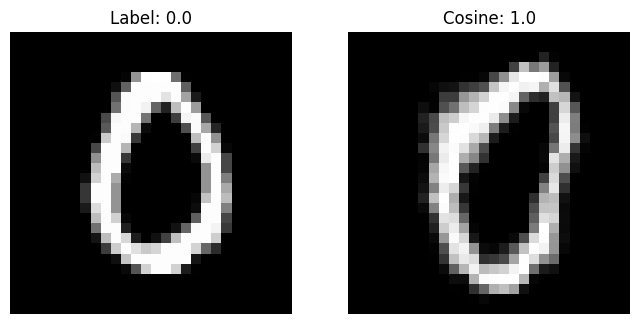

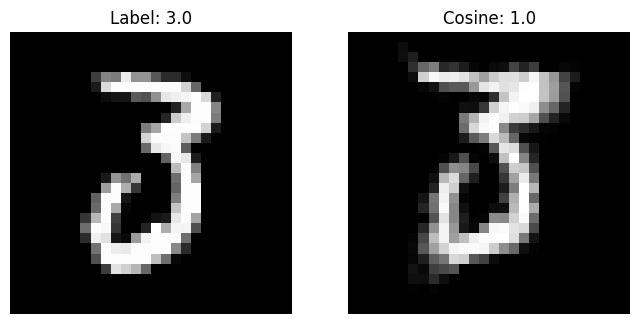

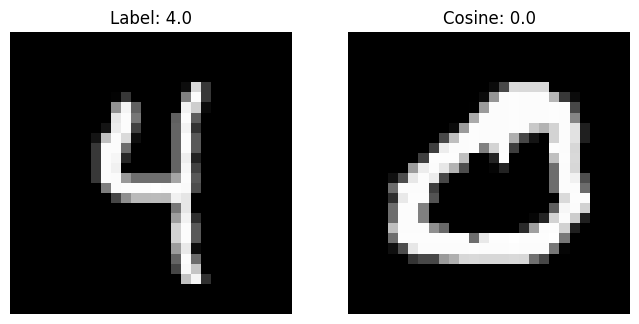

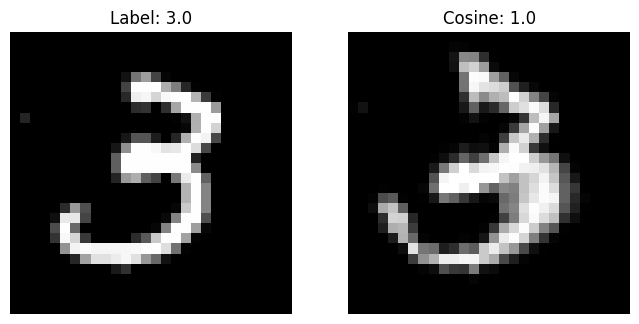

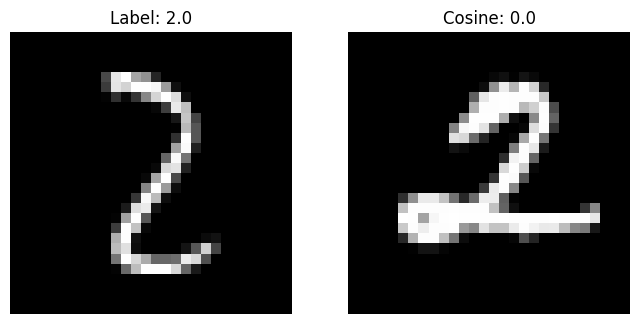

In [67]:
for i in range(5):
    plot_dataset_sample(non_contra_dataset, i, contrastive = False)

#### 1. Experiment: non_contrastive vanilla:

In [16]:
EPOCHS = 15
net_1 = Network()
# define optimizer
optimizer_1 = optim.Adam(net_1.parameters(), lr=0.0001)
# define loss function
loss_function = CosineLoss()

In [17]:
lrs_1 = []
losses_1 = []
scheduler = optim.lr_scheduler.StepLR(optimizer_1, step_size=40, gamma=0.85)
# torch training loop
for epoch in range(EPOCHS):
    epoch_loss = 0
    batches=0
    print('epoch -', epoch)
    lrs_1.append(optimizer_1.param_groups[0]['lr'])
    print('learning rate', lrs_1[-1])
    for id, first, second, dis, label in tqdm(non_train_loader):
        batches+=1
        optimizer_1.zero_grad()
        first_out = net_1(first)
        second_out = net_1(second)
        dis = dis.to(torch.float32)
        loss = loss_function(first_out, second_out, dis)
        loss = torch.mean(loss)
        epoch_loss+=loss
        loss.backward()
        optimizer_1.step()
    # append epoch loss for plotting
    losses_1.append(epoch_loss.cpu().detach().numpy()/batches)
    # scheduler step at every epoch
    scheduler.step()
    print('epoch_loss', losses_1[-1])

epoch - 0
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.24056382477283478
epoch - 1
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.20720595121383667
epoch - 2
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.18721118569374084
epoch - 3
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.16688397526741028
epoch - 4
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.14964452385902405
epoch - 5
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.1419004499912262
epoch - 6
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.13529972732067108
epoch - 7
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.12874962389469147
epoch - 8
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.12497792392969131
epoch - 9
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.11473380774259567
epoch - 10
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.10026596486568451
epoch - 11
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.10375328361988068
epoch - 12
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.09921269118785858
epoch - 13
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.08798125386238098
epoch - 14
learning rate 0.0001


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.0934445783495903


In [18]:
def get_representations(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = X.view(-1, 1, 28, 28)  # Reshape X to (batch_size, 1, 28, 28)
        representations = model(X_tensor).detach()
    return representations

# Get the representations
representations_1 = get_representations(net_1, non_X)

# Apply K-means clustering on original X
kmeans_original_1 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_original_1.fit(non_X)
predictions_original_1 = kmeans_original_1.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_1 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_representations_1.fit(representations_1)
predictions_representations_1 = kmeans_representations_1.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_1 = adjusted_rand_score(non_Y, predictions_original_1)
ari_representations_1 = adjusted_rand_score(non_Y, predictions_representations_1)

print(f'Adjusted Rand Index (ARI) for original X: {ari_original_1}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_1}')

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7403377973121414
Adjusted Rand Index (ARI) for representations: 0.7345917544638364


#### Experiment 2: Tensorized:

In [68]:
#  (contrastive, loss_fn, cosine)
experiments = {
    1: (False, CosineLoss(),True),
    2: (True, CosineLoss(),True),
    3: (True, ContrastiveLoss(),False)
}

ELASTIC=True
CENTER=False
CLASS_KNOWLEDGE = False

CONTRASTIVE,loss_fn,COSINE = experiments.get(1)
non_contra_dataset, non_X, non_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic=ELASTIC
)
non_train_loader = DataLoader(non_contra_dataset, batch_size=BATCH, shuffle=True)

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


In [70]:
net_2, train_loss_2, clust_assign_2, embeddings_2 = train(non_X,non_Y,non_train_loader, n_tensors=NUM_TENSORS,in_feature=-1,embed=EMBED, contrastive=CONTRASTIVE,epochs=30, lr=0.0001, cosine=COSINE, center_points = CENTER)

clust_assign in the beginning:  tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
-0.00023060964912104676
epoch  1  loss  0.24295641295611858


Epoch 2/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.008805357276246
epoch  2  loss  0.2404398862272501


Epoch 3/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.008350856679453475
epoch  3  loss  0.23292822018265724


Epoch 4/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.004261611160999785
epoch  4  loss  0.22375100664794445


Epoch 5/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.0013343908114030678
epoch  5  loss  0.2175191156566143


Epoch 6/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.006849318696903602
epoch  6  loss  0.21916032768785954


Epoch 7/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.013731315719351853
epoch  7  loss  0.20478175580501556


Epoch 8/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.004924784344425595
epoch  8  loss  0.19041889533400536


Epoch 9/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.010310684884909849
epoch  9  loss  0.19505180604755878


Epoch 10/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.02547191821020355
epoch  10  loss  0.18932198733091354


Epoch 11/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.03665073263531239
epoch  11  loss  0.18695413880050182


Epoch 12/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.02445516164028632
epoch  12  loss  0.1786900982260704


Epoch 13/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.032100930434257165
epoch  13  loss  0.1746118050068617


Epoch 14/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.02308896213222159
epoch  14  loss  0.17004607059061527


Epoch 15/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.02150524451416851
epoch  15  loss  0.16800986416637897


Epoch 16/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.023046995470041617
epoch  16  loss  0.16781864501535892


Epoch 17/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.019378419135426334
epoch  17  loss  0.1596857775002718


Epoch 18/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.025340729278099036
epoch  18  loss  0.1537827681750059


Epoch 19/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.02250837012075735
epoch  19  loss  0.15237038768827915


Epoch 20/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.020140730360992506
epoch  20  loss  0.1519895289093256


Epoch 21/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.030102617450994303
epoch  21  loss  0.15174839086830616


Epoch 22/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.013754798096985484
epoch  22  loss  0.15083267726004124


Epoch 23/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.020168675984566502
epoch  23  loss  0.14908383414149284


Epoch 24/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.022766369478982397
epoch  24  loss  0.1439319010823965


Epoch 25/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.0351169332832405
epoch  25  loss  0.1450326107442379


Epoch 26/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.023334830966525593
epoch  26  loss  0.1348345298320055


Epoch 27/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.029766493637194875
epoch  27  loss  0.14131636917591095


Epoch 28/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.024633281383065586
epoch  28  loss  0.12834662850946188


Epoch 29/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.037362907282055685
epoch  29  loss  0.128000614233315


Epoch 30/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.025239738786720967
epoch  30  loss  0.13062439486384392
clust_assign in the beginning:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [71]:
# Apply K-means clustering on original X
kmeans_original_2 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_original_2.fit(non_X)
predictions_original_2 = kmeans_original_2.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_2 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_representations_2.fit(embeddings_2)
predictions_representations_2 = kmeans_representations_2.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_2 = adjusted_rand_score(non_Y, predictions_original_2)
ari_representations_2 = adjusted_rand_score(non_Y, predictions_representations_2)
ari_clust_2= adjusted_rand_score(torch.argmax(clust_assign_2,axis=0).cpu().detach().numpy(), non_Y.cpu().detach().numpy())
print(f'Adjusted Rand Index (ARI) for original X: {ari_original_2}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_2}')
print(f'Adjusted Rand Index (ARI) for clust_assign:{ari_clust_2}')


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7472851607200995
Adjusted Rand Index (ARI) for representations: 0.09635842874870577
Adjusted Rand Index (ARI) for clust_assign:0.025239738786720967


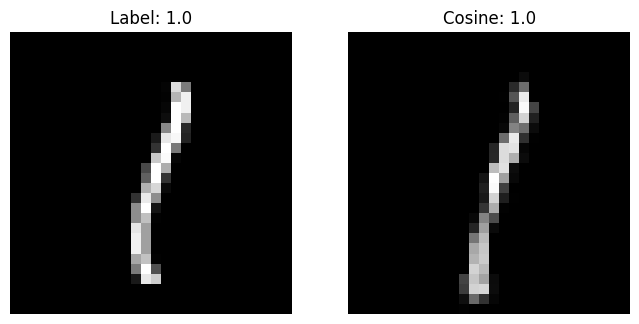

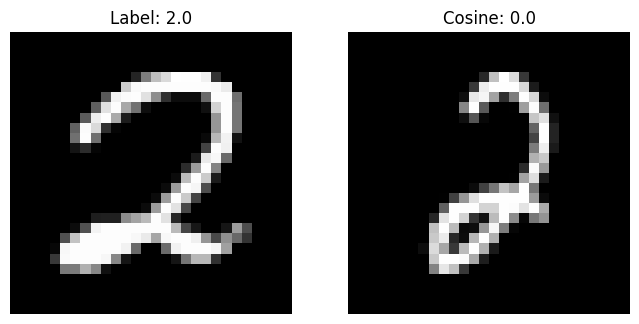

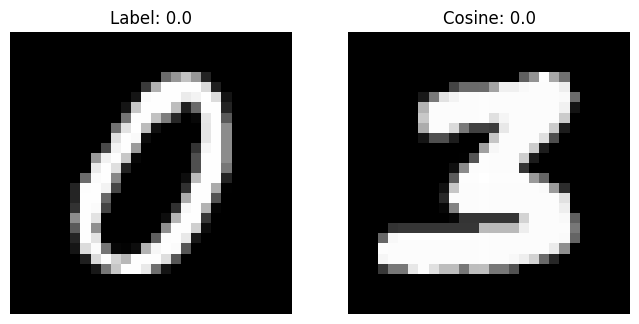

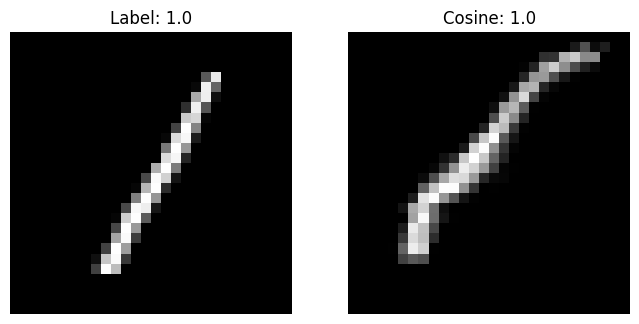

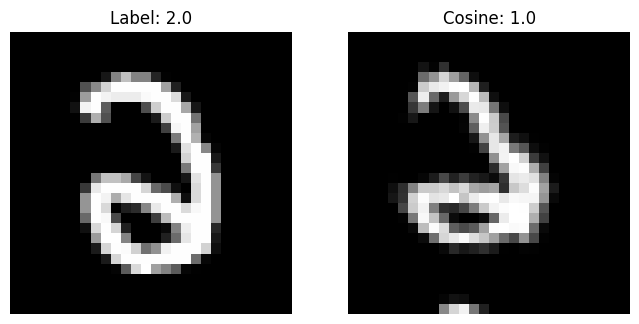

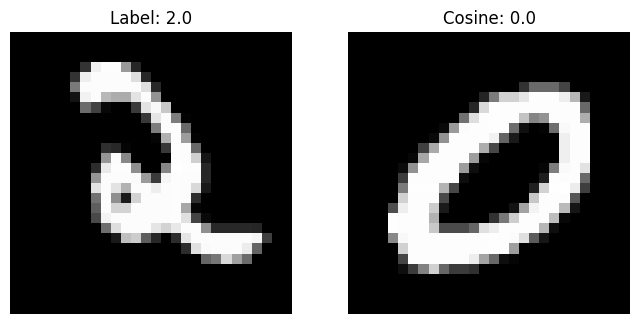

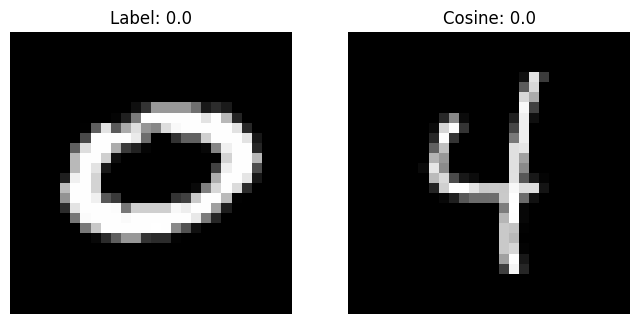

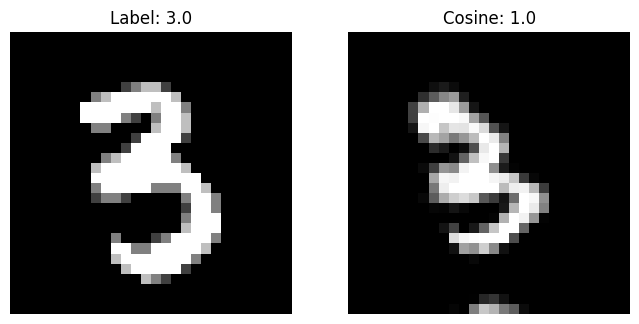

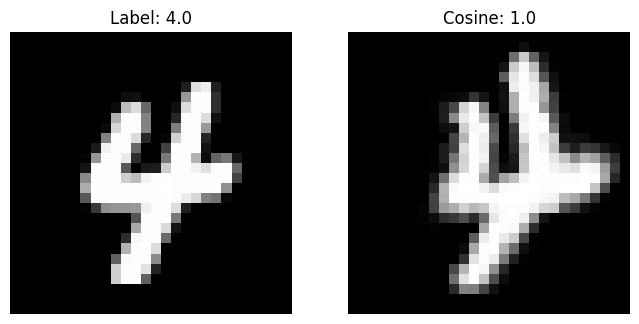

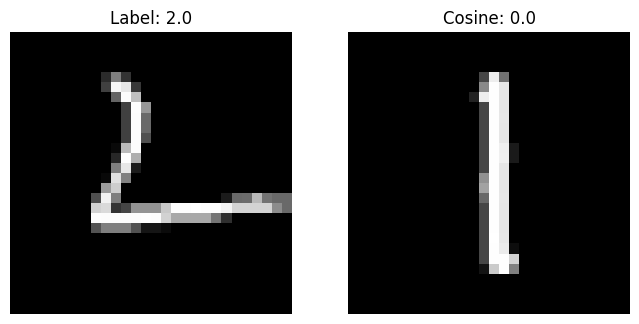

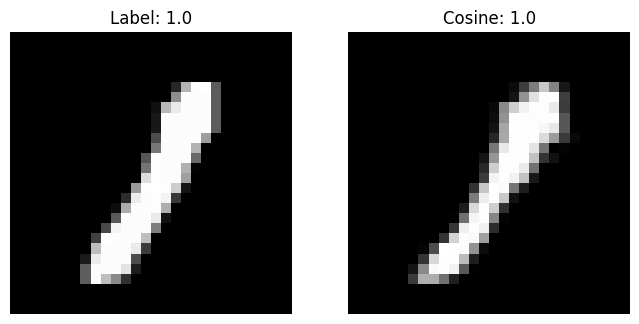

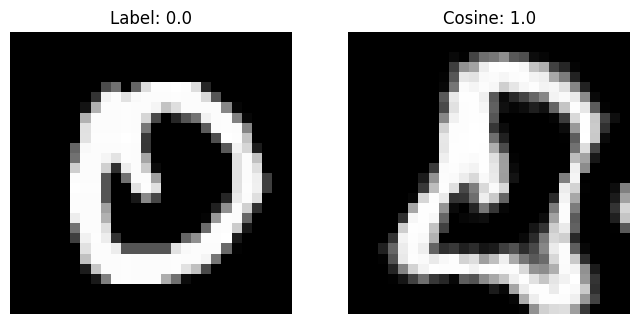

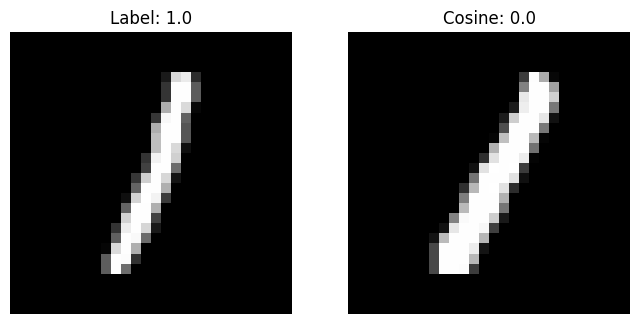

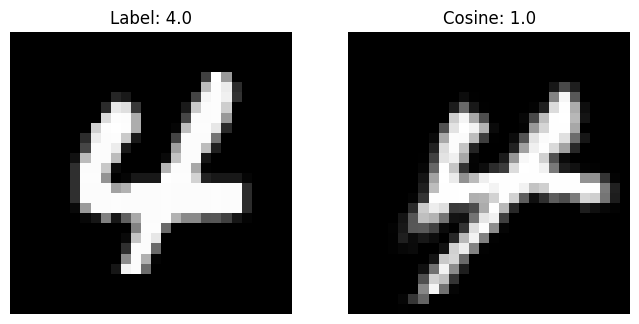

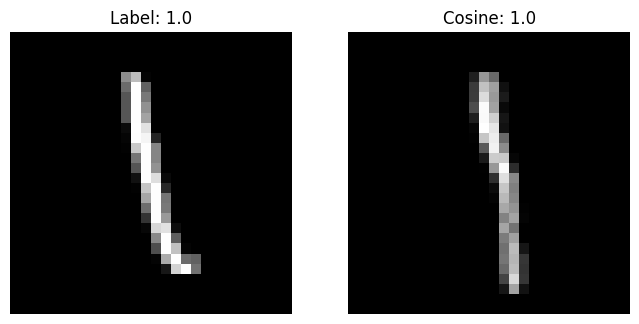

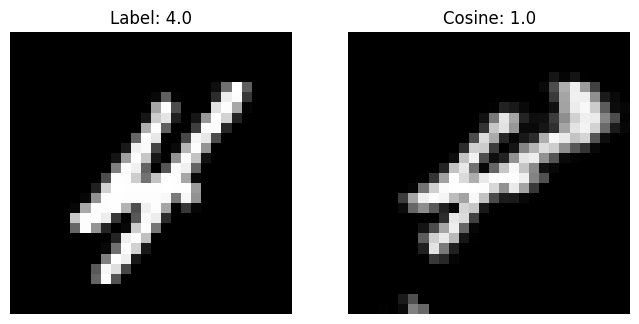

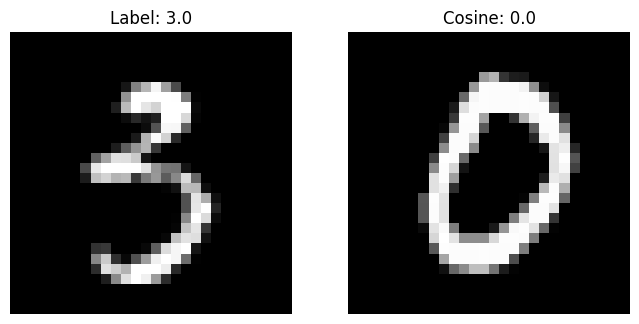

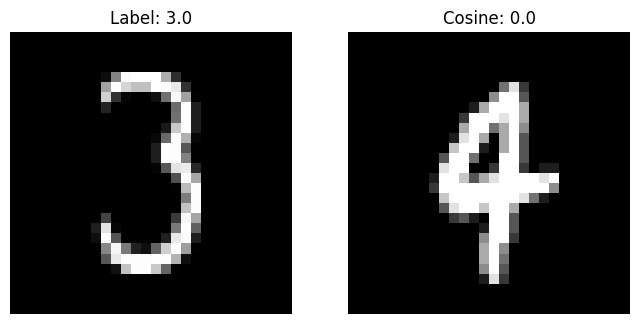

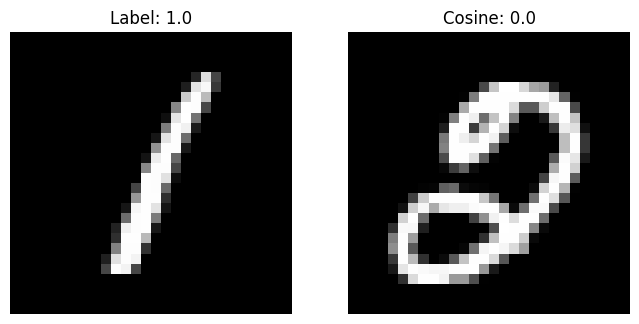

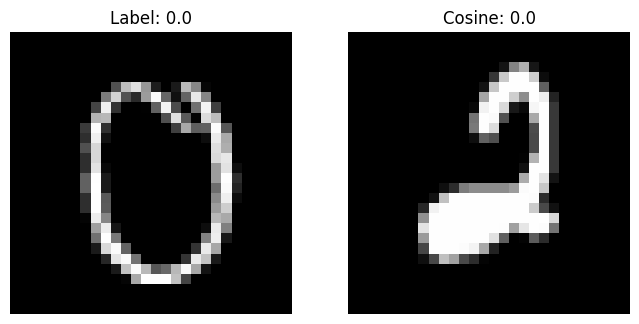

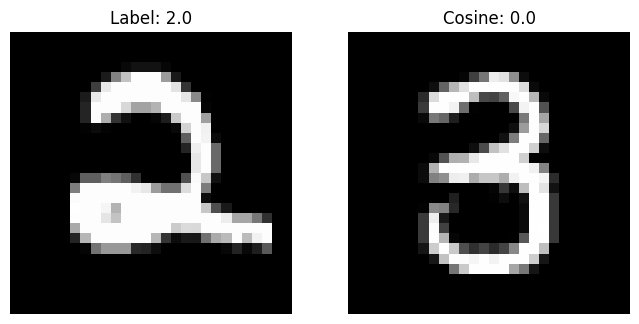

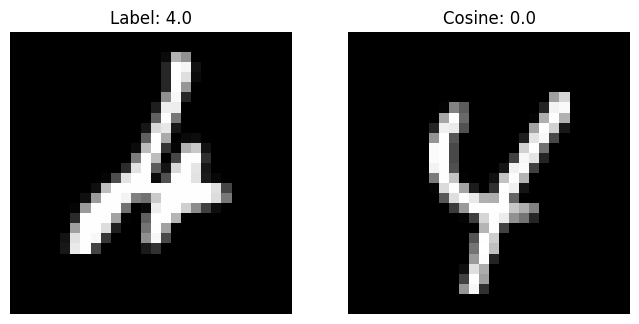

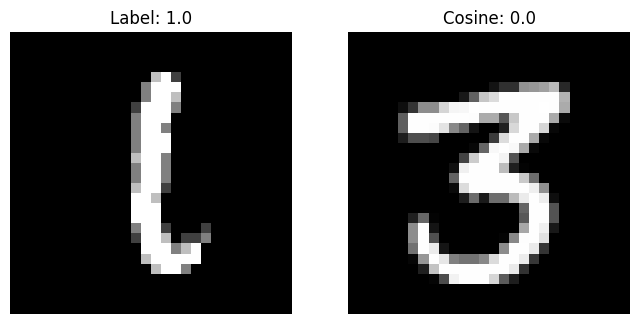

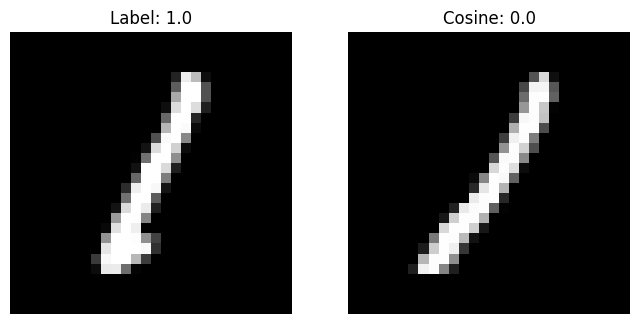

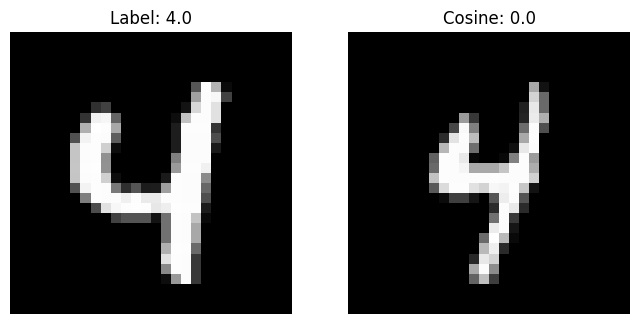

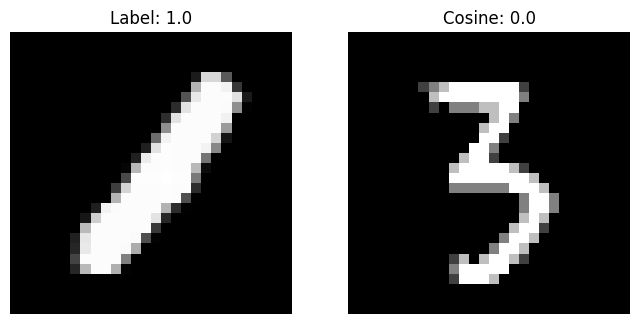

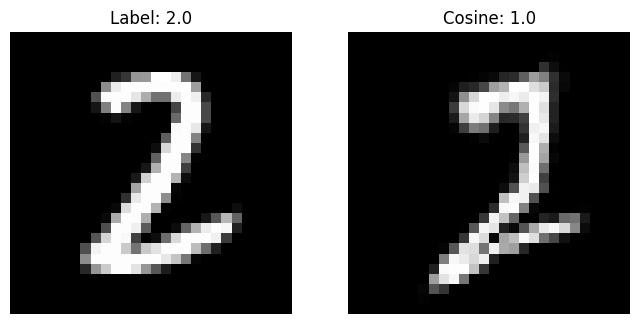

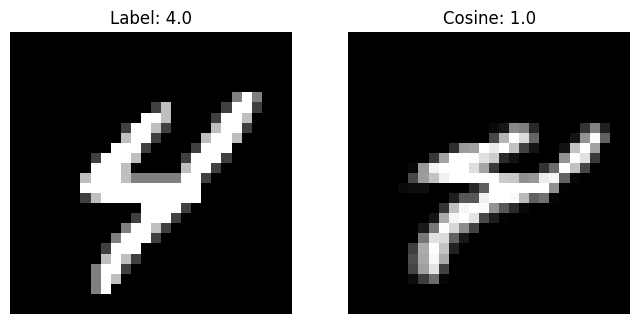

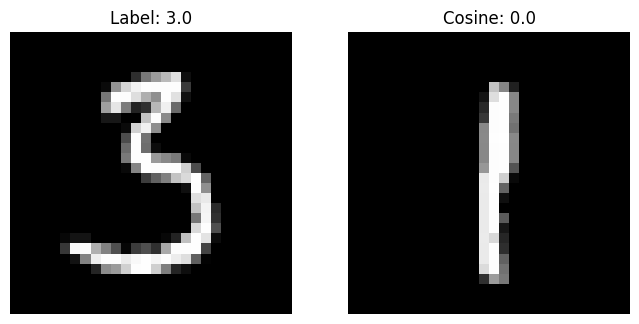

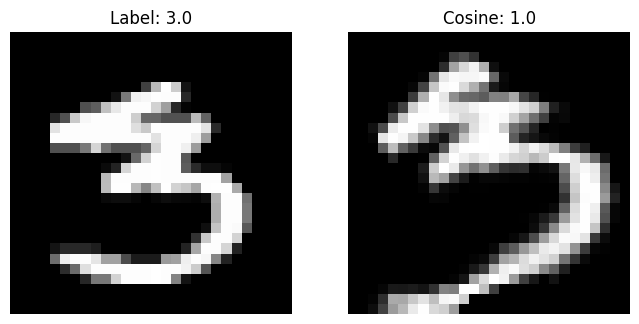

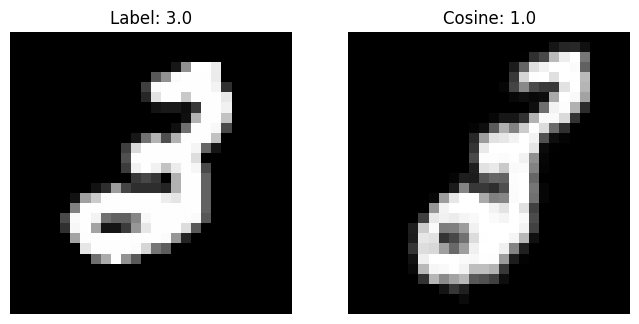

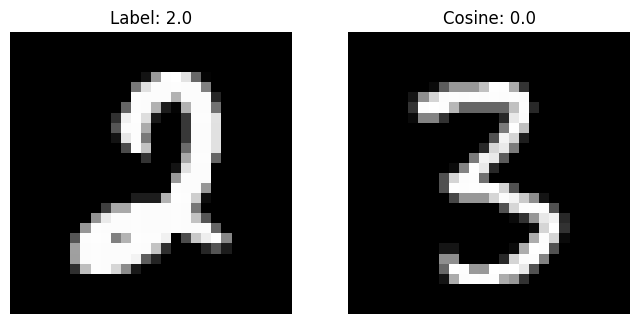

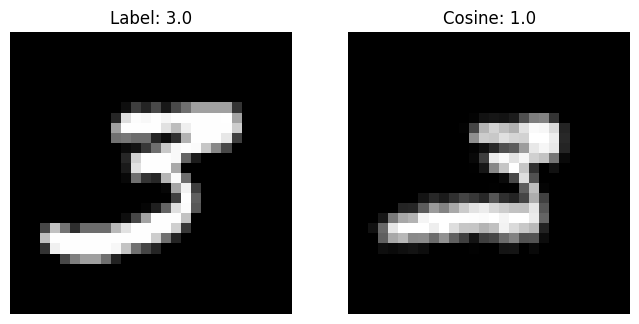

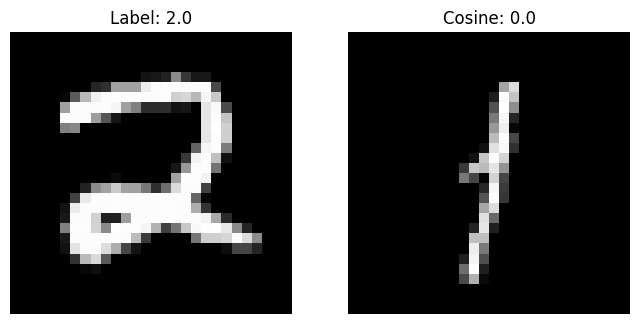

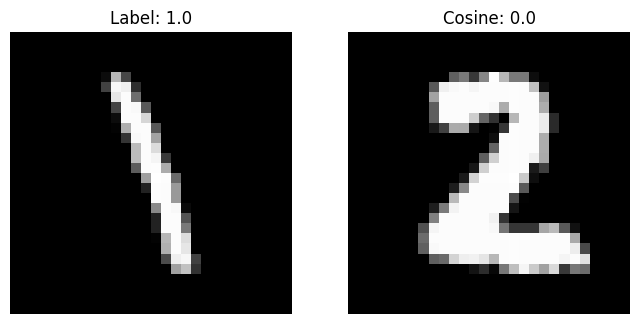

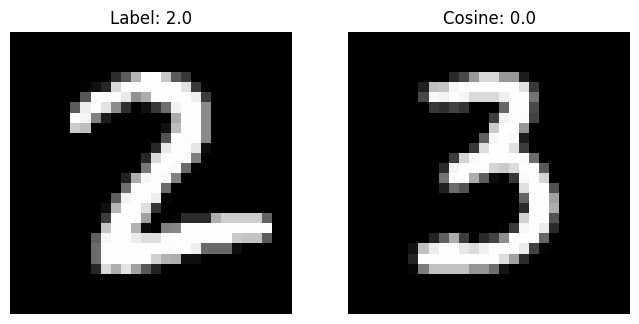

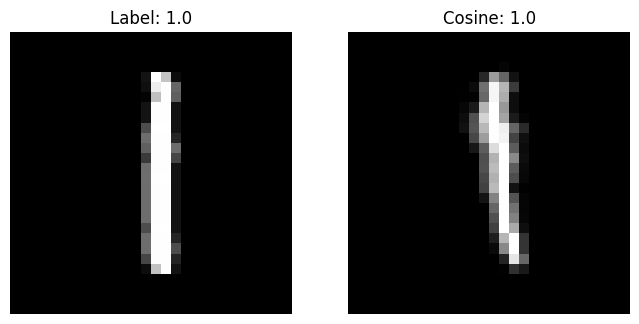

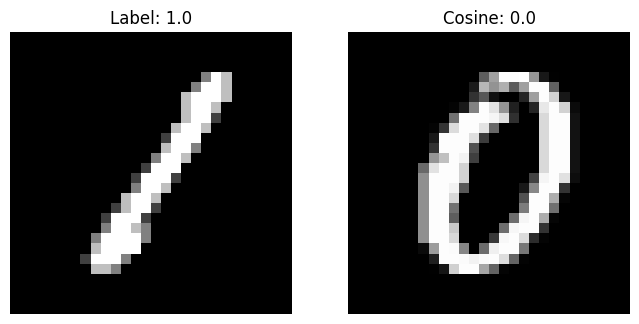

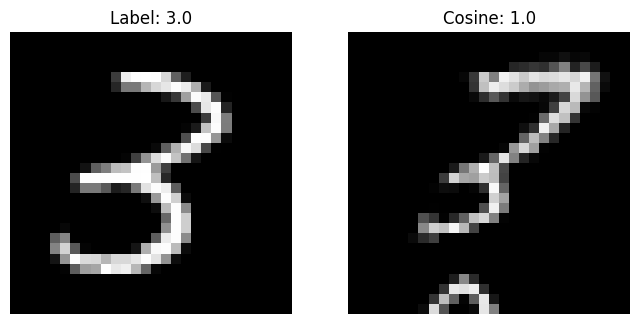

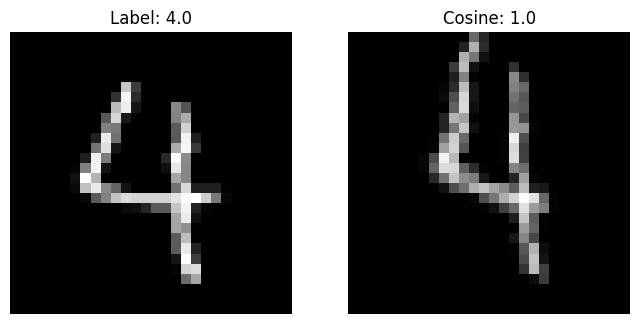

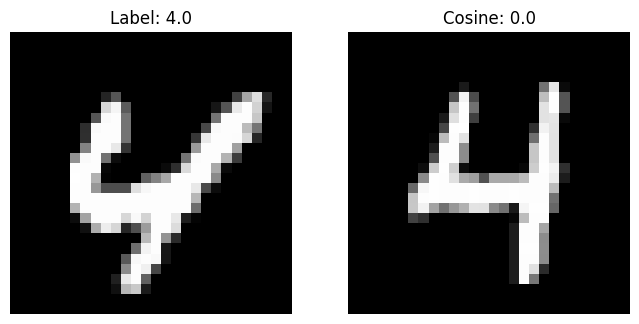

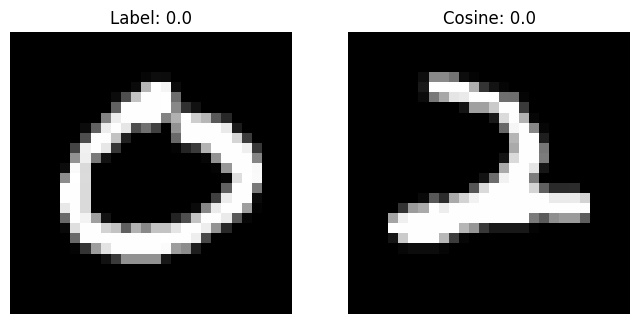

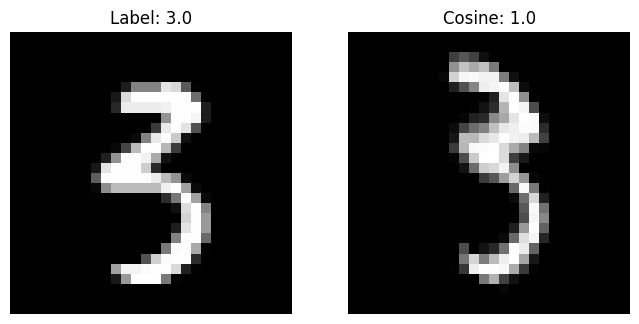

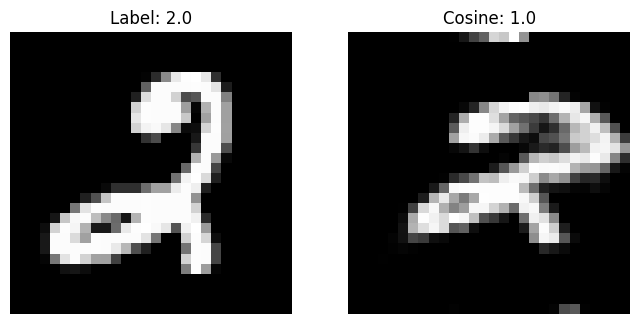

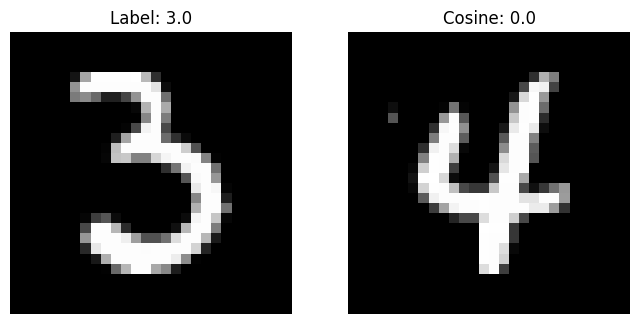

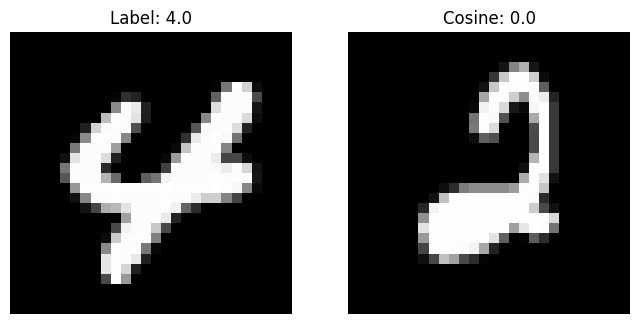

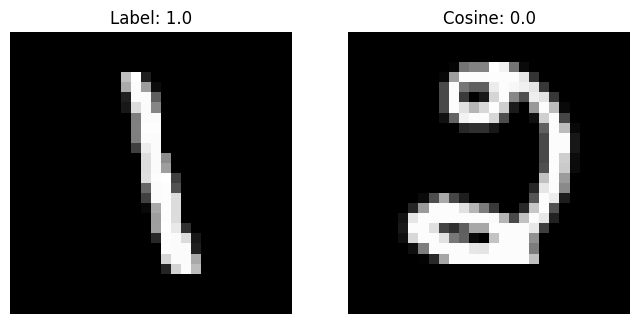

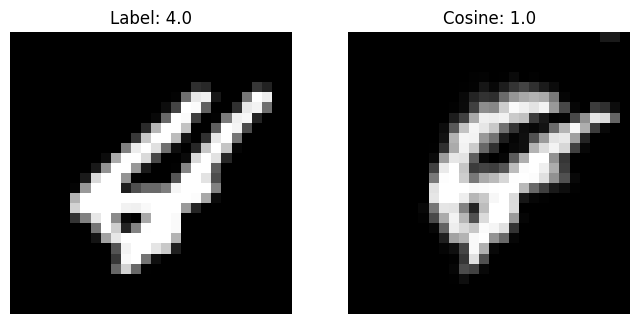

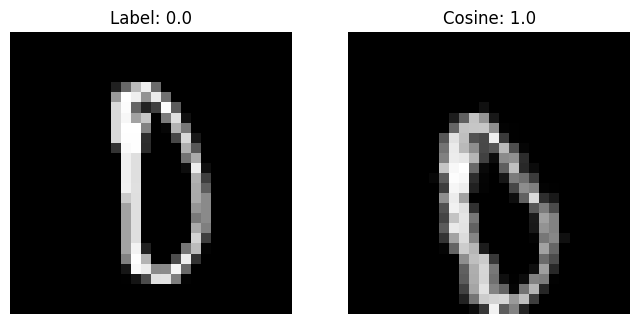

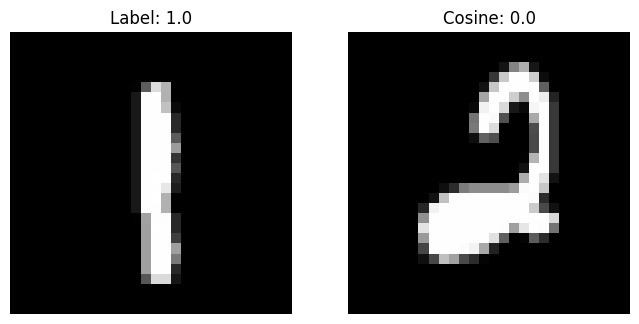

In [72]:
for i in range(50):
    plot_dataset_sample(non_contra_dataset, i, contrastive = False)

#### Now lets see the contrastive and tensorized model with the same loss
3. Vanilla:

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


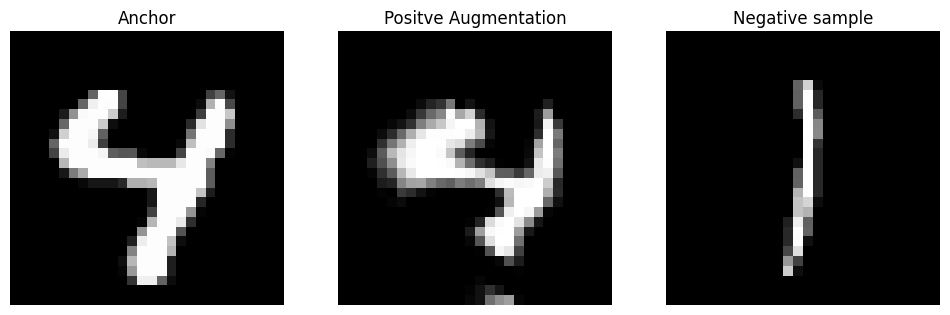

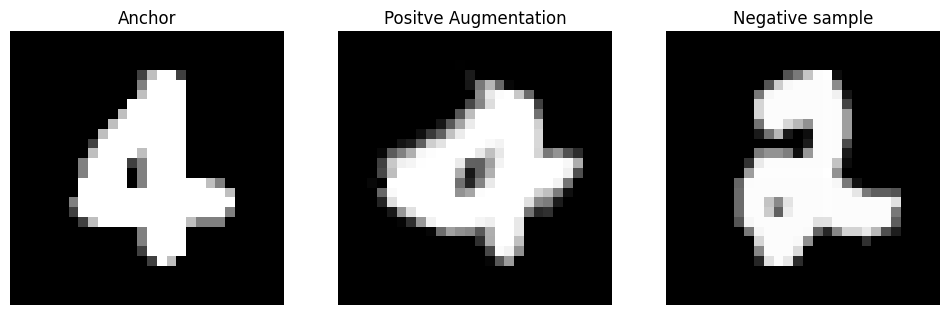

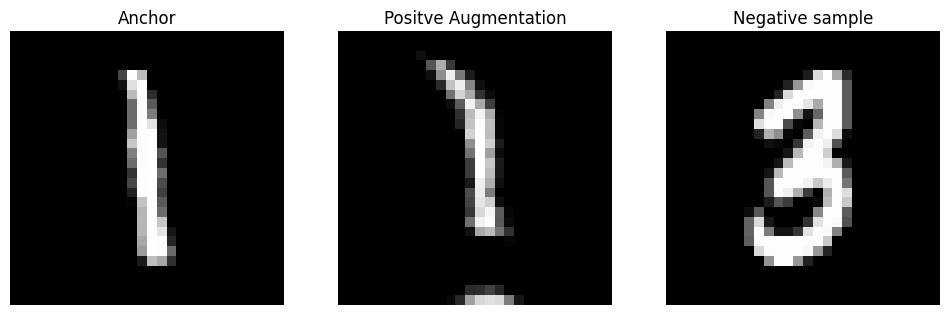

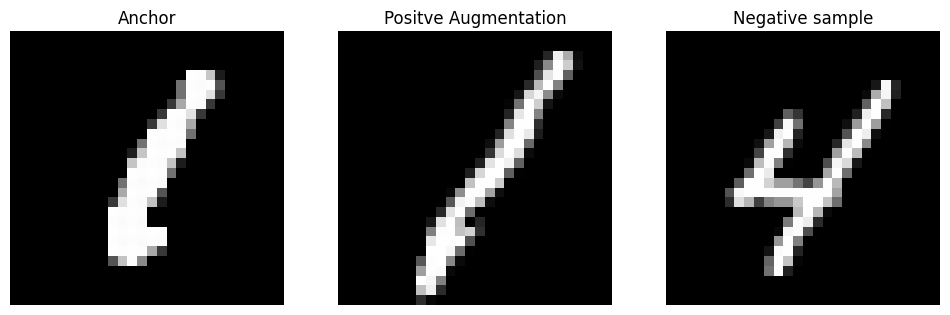

In [186]:
# False: pair of anchor and a second image, True: triplet
CONTRASTIVE = True 
EMBED = 128
BATCH = 128
NUM_SAMPLES = 1000
NUM_CLUSTERS=5
NUM_TENSORS = 5


CLASS_KNOWLEDGE = False
ELASTIC=True
CENTER = False


contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic = ELASTIC
)

# Use k-means++ to initialize cluster centers
centers, indices = kmeans_plusplus(contra_X.numpy(), n_clusters=NUM_TENSORS, random_state=20)
clust_assign = clust_matrix(contra_X, NUM_TENSORS, centers)
centers = update_centers(contra_X, centers, clust_assign, -1)

# Set initial clust_assign in the dataset
contra_dataset.set_clust_assign(clust_assign)
contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)
for i in range(4):
    plot_dataset_sample(contra_dataset, i, contrastive = True)

In [74]:
EPOCHS = 10
net_3 = Network()
# define optimizer
optimizer_3 = optim.Adam(net_3.parameters(), lr=0.00001)
# define loss function
loss_function = CosineLoss()

In [75]:
lrs_3 = []
losses_3 = []
scheduler = optim.lr_scheduler.StepLR(optimizer_3, step_size=40, gamma=0.85)
# torch training loop
for epoch in range(EPOCHS):
    epoch_loss = 0
    batches=0
    print('epoch -', epoch)
    lrs_3.append(optimizer_3.param_groups[0]['lr'])
    print('learning rate', lrs_3[-1])
    for idx, anchor, positive, negative, pos_dis, neg_dis, label in tqdm(contra_train_loader):
        batches+=1
        optimizer_3.zero_grad()
        anchor_out = net(anchor)
        positive_out = net(positive)
        negative_out = net(negative)
        
        pos_dis = pos_dis.to(torch.float32)
        neg_dis = neg_dis.to(torch.float32)
        
        pos_loss = loss_function(anchor_out, positive_out, pos_dis)
        neg_loss = loss_function(anchor_out, negative_out, neg_dis)
        
        loss = pos_loss + neg_loss
        loss = loss/2
        loss=loss.mean()
        epoch_loss += loss.item()
        loss.backward()
        optimizer_3.step()
    
    losses_3.append(epoch_loss / batches)
    scheduler.step()
    print('epoch_loss', losses_3[-1])

epoch - 0
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2543809749186039
epoch - 1
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2549259550869465
epoch - 2
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2562269903719425
epoch - 3
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2496838141232729
epoch - 4
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2542718481272459
epoch - 5
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.25308628752827644
epoch - 6
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2552165314555168
epoch - 7
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2531538885086775
epoch - 8
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2541130781173706
epoch - 9
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss 0.2527380585670471


In [76]:
# Get the representations
representations_3 = get_representations(net_3, contra_X)

# Apply K-means clustering on original X
num_clusters = NUM_CLUSTERS
kmeans_original_3 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_original_3.fit(contra_X)
predictions_original_3 = kmeans_original_3.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_3 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_representations_3.fit(representations_3)
predictions_representations_3 = kmeans_representations_3.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_3 = adjusted_rand_score(contra_Y, predictions_original_3)
ari_representations_3 = adjusted_rand_score(contra_Y, predictions_representations_3)

print(f'Adjusted Rand Index (ARI) for original X: {ari_original_3}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_3}')

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7388738867059191
Adjusted Rand Index (ARI) for representations: 0.4596897308955555


##### Experiment 4: Tensorized

In [77]:
CONTRASTIVE,loss_fn,COSINE = experiments.get(2)

ELASTIC=True
CENTER=False
CLASS_KNOWLEDGE = False


contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic=ELASTIC
)
contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


In [86]:
net_4, train_loss_4, clust_assign_4, embeddings_4 = train(contra_X,contra_Y,contra_train_loader, n_tensors=NUM_TENSORS,in_feature=-1,embed=EMBED, contrastive=CONTRASTIVE,epochs=100, lr=0.0001,cosine=COSINE,loss_fn=loss_fn)

clust_assign in the beginning:  tensor([[0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]])


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.03579783171340323
epoch  1  loss  -1.9878448471426964


Epoch 2/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.11372264732532153
epoch  2  loss  -4.33343505859375


Epoch 3/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14468265817016335
epoch  3  loss  -25.876844882965088


Epoch 4/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14712073145109858
epoch  4  loss  -138.42486190795898


Epoch 5/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1392542942260784
epoch  5  loss  -613.3768844604492


Epoch 6/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.13564567792900836
epoch  6  loss  -2112.473976135254


Epoch 7/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14434246204966056
epoch  7  loss  -6546.406433105469


Epoch 8/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14114793270484152
epoch  8  loss  -16909.099731445312


Epoch 9/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14204121880980125
epoch  9  loss  -38307.392333984375


Epoch 10/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15311107356707118
epoch  10  loss  -85467.97265625


Epoch 11/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14458197349586419
epoch  11  loss  -165037.884765625


Epoch 12/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.13577486911639144
epoch  12  loss  -291053.314453125


Epoch 13/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.12906328181296528
epoch  13  loss  -489492.91796875


Epoch 14/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14004704129199683
epoch  14  loss  -832441.9921875


Epoch 15/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14789358733322264
epoch  15  loss  -1297943.1328125


Epoch 16/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14408418207133297
epoch  16  loss  -1990048.828125


Epoch 17/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1489720609541998
epoch  17  loss  -2994649.03125


Epoch 18/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15063142510755312
epoch  18  loss  -4299282.0625


Epoch 19/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1445327036132353
epoch  19  loss  -5838799.375


Epoch 20/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1322095660655063
epoch  20  loss  -8026515.0


Epoch 21/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14432202480879877
epoch  21  loss  -10870107.625


Epoch 22/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14166924867554959
epoch  22  loss  -14397167.625


Epoch 23/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1425043901244979
epoch  23  loss  -18905175.75


Epoch 24/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.147283149744802
epoch  24  loss  -25176560.75


Epoch 25/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15027349330082393
epoch  25  loss  -31599656.0


Epoch 26/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15192165946784714
epoch  26  loss  -40042033.0


Epoch 27/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1536922104350707
epoch  27  loss  -49898895.0


Epoch 28/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15452922373125105
epoch  28  loss  -60157075.5


Epoch 29/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1591424254136342
epoch  29  loss  -76465167.0


Epoch 30/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.174245674048625
epoch  30  loss  -89468553.0


Epoch 31/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18340139667463315
epoch  31  loss  -111691420.0


Epoch 32/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18122351242859913
epoch  32  loss  -128460960.0


Epoch 33/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1906061962293672
epoch  33  loss  -150303906.0


Epoch 34/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18410010254645062
epoch  34  loss  -179893686.0


Epoch 35/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.186203511931734
epoch  35  loss  -204006996.0


Epoch 36/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1686871376699121
epoch  36  loss  -231480482.0


Epoch 37/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17410805323704973
epoch  37  loss  -263290726.0


Epoch 38/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1879688267891873
epoch  38  loss  -329271620.0


Epoch 39/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18284697442284895
epoch  39  loss  -375415492.0


Epoch 40/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1838229459140417
epoch  40  loss  -413487604.0


Epoch 41/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17189457347741305
epoch  41  loss  -475031932.0


Epoch 42/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.19668947584535135
epoch  42  loss  -543081044.0


Epoch 43/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17148486601773247
epoch  43  loss  -644321904.0


Epoch 44/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18772313230360438
epoch  44  loss  -687499792.0


Epoch 45/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18485831623609653
epoch  45  loss  -778205752.0


Epoch 46/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1817902113588734
epoch  46  loss  -876503264.0


Epoch 47/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.19790589778264922
epoch  47  loss  -1012244960.0


Epoch 48/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18364215331249306
epoch  48  loss  -1122643520.0


Epoch 49/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18773907380954943
epoch  49  loss  -1254632672.0


Epoch 50/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.20447303027030675
epoch  50  loss  -1417343200.0


Epoch 51/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1916877674870195
epoch  51  loss  -1632201808.0


Epoch 52/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18223740156344842
epoch  52  loss  -1777339200.0


Epoch 53/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1857174260875888
epoch  53  loss  -1972018160.0


Epoch 54/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18473423943887138
epoch  54  loss  -2247211152.0


Epoch 55/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18869424528207118
epoch  55  loss  -2431659104.0


Epoch 56/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17526254098251343
epoch  56  loss  -2673018752.0


Epoch 57/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16999344914217573
epoch  57  loss  -2835945888.0


Epoch 58/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17569878795578664
epoch  58  loss  -3215313376.0


Epoch 59/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16093932535195563
epoch  59  loss  -3482553120.0


Epoch 60/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1723351972289112
epoch  60  loss  -3819208992.0


Epoch 61/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16466514396009735
epoch  61  loss  -4301805888.0


Epoch 62/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17574662647959013
epoch  62  loss  -4734783936.0


Epoch 63/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1770051187923411
epoch  63  loss  -5204590720.0


Epoch 64/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17507501718247706
epoch  64  loss  -5670581248.0


Epoch 65/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1653092355714459
epoch  65  loss  -6052318912.0


Epoch 66/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17087481195884519
epoch  66  loss  -6407356672.0


Epoch 67/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17445404053800329
epoch  67  loss  -7064525312.0


Epoch 68/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17577044909847012
epoch  68  loss  -7756828416.0


Epoch 69/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1686881600449998
epoch  69  loss  -8245656256.0


Epoch 70/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17315010897864558
epoch  70  loss  -8763540352.0


Epoch 71/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16696375646442013
epoch  71  loss  -9566009088.0


Epoch 72/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17643965385373636
epoch  72  loss  -10564685312.0


Epoch 73/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16188468798755776
epoch  73  loss  -11411060480.0


Epoch 74/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15212164118915503
epoch  74  loss  -12072155136.0


Epoch 75/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14745024544165164
epoch  75  loss  -12771121152.0


Epoch 76/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15968582341612308
epoch  76  loss  -14004626432.0


Epoch 77/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15125402485759915
epoch  77  loss  -14675921024.0


Epoch 78/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16308466599574922
epoch  78  loss  -15576321792.0


Epoch 79/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16390757553152807
epoch  79  loss  -16099400448.0


Epoch 80/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17422303405939707
epoch  80  loss  -18097949696.0


Epoch 81/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16651100555946502
epoch  81  loss  -19294951040.0


Epoch 82/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16394863949186184
epoch  82  loss  -20371279872.0


Epoch 83/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1545116883622248
epoch  83  loss  -21154459392.0


Epoch 84/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1688694597447142
epoch  84  loss  -23407813888.0


Epoch 85/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1610406690689237
epoch  85  loss  -24396783872.0


Epoch 86/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17611562429438218
epoch  86  loss  -27132707328.0


Epoch 87/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15226300572498863
epoch  87  loss  -27762397440.0


Epoch 88/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16194707542303544
epoch  88  loss  -29478410240.0


Epoch 89/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16545547822015846
epoch  89  loss  -31312503296.0


Epoch 90/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1578130288233122
epoch  90  loss  -32865385472.0


Epoch 91/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16247514305837585
epoch  91  loss  -34779439616.0


Epoch 92/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14704795156995557
epoch  92  loss  -36196872704.0


Epoch 93/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15723111227129796
epoch  93  loss  -38247535104.0


Epoch 94/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14714911146211748
epoch  94  loss  -40458935808.0


Epoch 95/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1419902102822654
epoch  95  loss  -43165783552.0


Epoch 96/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1403409449078797
epoch  96  loss  -44486024704.0


Epoch 97/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15239369800502048
epoch  97  loss  -47541203968.0


Epoch 98/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15859059297850314
epoch  98  loss  -50267723264.0


Epoch 99/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1705998997085231
epoch  99  loss  -51795504640.0


Epoch 100/100:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16259855022523406
epoch  100  loss  -55054898688.0
clust_assign in the beginning:  tensor([[0., 0., 1.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.]])


In [87]:
representations_4 = embeddings_4

# Apply K-means clustering on original X
kmeans_original_4 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_original_4.fit(contra_X)
predictions_original_4 = kmeans_original_4.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_4 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_representations_4.fit(representations_4)
predictions_representations_4 = kmeans_representations_4.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_4 = adjusted_rand_score(contra_Y, predictions_original_4)
ari_representations_4 = adjusted_rand_score(contra_Y, predictions_representations_4)
ari_clust_4= adjusted_rand_score(torch.argmax(clust_assign_4,axis=0).cpu().detach().numpy(), contra_Y.cpu().detach().numpy())
print(f'Adjusted Rand Index (ARI) for original X: {ari_original_4}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_4}')
print(f'Adjusted Rand Index (ARI) for clust_assign:{ari_clust_4}')


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7717671441962006
Adjusted Rand Index (ARI) for representations: 0.0988973375631452
Adjusted Rand Index (ARI) for clust_assign:0.16259855022523406


### Now lets try the contrastive loss
##### For the contrastive loss only the triplet dataset will be used.
##### Experiment 5: Vanilla

In [137]:
# False: pair of anchor and a second image, True: triplet
CONTRASTIVE = True 
EMBED = 128
BATCH = 128
NUM_SAMPLES = 1000
NUM_CLUSTERS=5
NUM_TENSORS = 5

CLASS_KNOWLEDGE = False
ELASTIC=True
CENTER = False

contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic = ELASTIC
)

# Use k-means++ to initialize cluster centers
centers, indices = kmeans_plusplus(contra_X.numpy(), n_clusters=NUM_TENSORS, random_state=20)
clust_assign = clust_matrix(contra_X, NUM_TENSORS, centers)
centers = update_centers(contra_X, centers, clust_assign, -1)

# Set initial clust_assign in the dataset
contra_dataset.set_clust_assign(clust_assign)
contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)


MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


In [138]:
EPOCHS = 10
net_5 = Network()
# define optimizer
optimizer_5 = optim.Adam(net_5.parameters(), lr=0.00001)
# define loss function
loss_function = ContrastiveLoss()

In [139]:
lrs_5 = []
losses_5 = []
scheduler = optim.lr_scheduler.StepLR(optimizer_5, step_size=40, gamma=0.85)
# torch training loop
for epoch in range(EPOCHS):
    epoch_loss = 0
    batches=0
    print('epoch -', epoch)
    lrs_5.append(optimizer_5.param_groups[0]['lr'])
    print('learning rate', lrs_5[-1])
    for idx, anchor, positive, negative, pos_dis, neg_dis, label in tqdm(contra_train_loader):
        batches+=1
        optimizer_5.zero_grad()
        anchor_out = net(anchor)
        positive_out = net(positive)
        negative_out = net(negative)
        loss = loss_function(anchor_out, positive_out, negative_out)
        loss=loss.mean()
        epoch_loss += loss.item()
        loss.backward()
        optimizer_5.step()
    
    losses_5.append(epoch_loss / batches)
    scheduler.step()
    print('epoch_loss', losses_5[-1])

epoch - 0
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3924063667654991
epoch - 1
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.4297308810055256
epoch - 2
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.4380581844598055
epoch - 3
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.4154610997065902
epoch - 4
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.4173027314245701
epoch - 5
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.43841305933892727
epoch - 6
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.35769336484372616
epoch - 7
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.4027741588652134
epoch - 8
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.5076944567263126
epoch - 9
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.48461588844656944


In [140]:
# Get the representations
representations_5 = get_representations(net_5, contra_X)

# Apply K-means clustering on original X
num_clusters = NUM_CLUSTERS
kmeans_original_5 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_original_5.fit(contra_X)
predictions_original_5 = kmeans_original_5.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_5 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_representations_5.fit(representations_5)
predictions_representations_5 = kmeans_representations_5.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_5 = adjusted_rand_score(contra_Y, predictions_original_5)
ari_representations_5 = adjusted_rand_score(contra_Y, predictions_representations_5)

print(f'Adjusted Rand Index (ARI) for original X: {ari_original_5}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_5}')

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7115042777132763
Adjusted Rand Index (ARI) for representations: 0.5486110008349427


##### Experiment 6: Tensorized

In [141]:
CONTRASTIVE,loss_fn,COSINE = experiments.get(3)

ELASTIC=True
CENTER=False
CLASS_KNOWLEDGE = False

contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic=ELASTIC
)

contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)


MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


In [142]:
net_6, train_loss_6, clust_assign_6, embeddings_6 = train(contra_X,contra_Y,contra_train_loader, n_tensors=NUM_TENSORS,in_feature=-1,embed=EMBED, contrastive=CONTRASTIVE,epochs=30, lr=0.0001,cosine=COSINE,loss_fn=loss_fn)

clust_assign in the beginning:  tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.035313158421552075
epoch  1  loss  -2.022958241403103


Epoch 2/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.10920799568370662
epoch  2  loss  -4.749282985925674


Epoch 3/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.13391360716287395
epoch  3  loss  -25.482253909111023


Epoch 4/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1245535899331267
epoch  4  loss  -132.8809461593628


Epoch 5/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14122826740157288
epoch  5  loss  -573.1478309631348


Epoch 6/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.12545504183144743
epoch  6  loss  -2044.4714965820312


Epoch 7/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.13209415370257024
epoch  7  loss  -6314.696807861328


Epoch 8/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14483374602619
epoch  8  loss  -17822.202880859375


Epoch 9/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14986623361287882
epoch  9  loss  -42051.7939453125


Epoch 10/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1480451461339639
epoch  10  loss  -85616.4716796875


Epoch 11/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15547941371855958
epoch  11  loss  -168297.306640625


Epoch 12/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1487387264876974
epoch  12  loss  -304304.337890625


Epoch 13/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1516994750612413
epoch  13  loss  -538358.828125


Epoch 14/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14167620181615417
epoch  14  loss  -878040.1953125


Epoch 15/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14347408611315376
epoch  15  loss  -1376518.5078125


Epoch 16/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14512446311307456
epoch  16  loss  -2081923.515625


Epoch 17/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14112918903019164
epoch  17  loss  -3102850.78125


Epoch 18/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14315728197103983
epoch  18  loss  -4460746.5625


Epoch 19/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14563218391291632
epoch  19  loss  -6076448.1875


Epoch 20/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14517189685145665
epoch  20  loss  -8704635.0


Epoch 21/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14917679738182277
epoch  21  loss  -11941984.375


Epoch 22/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14675769452441725
epoch  22  loss  -15055630.5


Epoch 23/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14305217989188024
epoch  23  loss  -19080954.125


Epoch 24/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14497886177948
epoch  24  loss  -24620280.75


Epoch 25/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14705990975511646
epoch  25  loss  -30656178.0


Epoch 26/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14785299132336435
epoch  26  loss  -38619061.0


Epoch 27/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14352992852317017
epoch  27  loss  -48881093.0


Epoch 28/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14723826757723488
epoch  28  loss  -58316387.5


Epoch 29/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1639842058491804
epoch  29  loss  -72967807.0


Epoch 30/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16062049288834884
epoch  30  loss  -89158037.0
clust_assign in the beginning:  tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [143]:
representations_6 = embeddings_6

# Apply K-means clustering on original X
kmeans_original_6 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_original_6.fit(contra_X)
predictions_original_6 = kmeans_original_6.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_6 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_representations_6.fit(representations_6)
predictions_representations_6 = kmeans_representations_6.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_6 = adjusted_rand_score(contra_Y, predictions_original_6)
ari_representations_6 = adjusted_rand_score(contra_Y, predictions_representations_6)
ari_clust_6= adjusted_rand_score(torch.argmax(clust_assign_6,axis=0).cpu().detach().numpy(), contra_Y.cpu().detach().numpy())
print(f'Adjusted Rand Index (ARI) for original X: {ari_original_6}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_6}')
print(f'Adjusted Rand Index (ARI) for clust_assign:{ari_clust_6}')


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7005364090270361
Adjusted Rand Index (ARI) for representations: 0.13035781103276958
Adjusted Rand Index (ARI) for clust_assign:0.16062049288834884


#### Visualizing the embeddings


Contrastive loss without class knowledge:


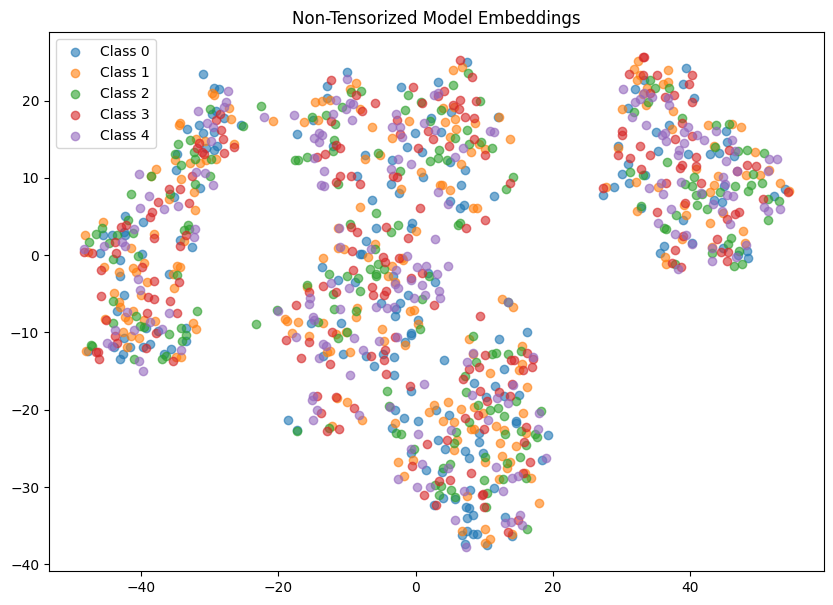

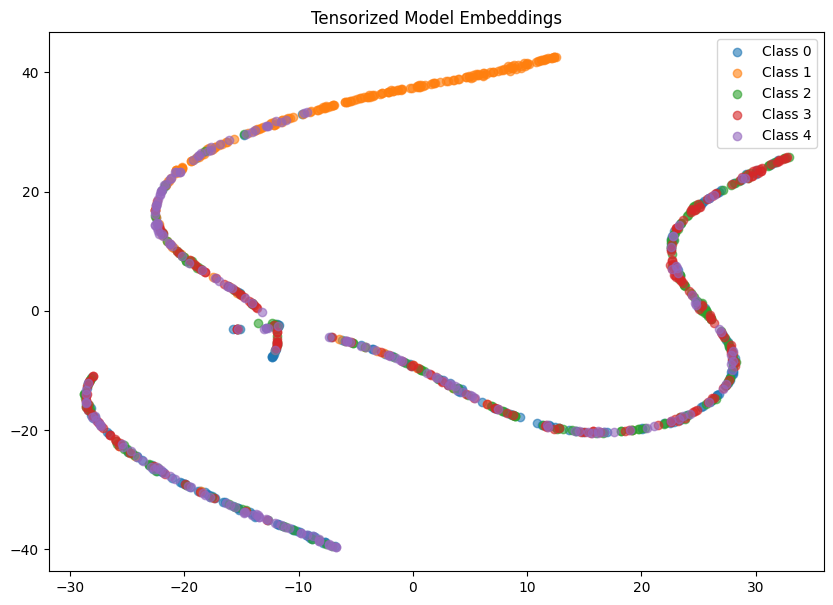

In [144]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def inspect_embeddings(embeddings, labels, title="Embeddings Visualization"):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    labels = labels.cpu().numpy() if hasattr(labels, 'cpu') else labels  # Ensure labels are numpy array
    unique_labels = np.unique(labels)  # Get unique labels
    
    plt.figure(figsize=(10, 7))
    
    for label in unique_labels:
        idx = labels == label
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Class {label}', alpha=0.6)
    
    plt.legend()
    plt.title(title)
    plt.show()

# After training the models
print("Contrastive loss without class knowledge:")
inspect_embeddings(representations_5, contra_Y, title="Non-Tensorized Model Embeddings")
inspect_embeddings(representations_6, contra_Y, title="Tensorized Model Embeddings")


We observe that the clusters in the tensorized embeddings are very tight and well-separated, yet the colors within these clusters are very mixed, it suggests that the model is forming clusters based on features that are not aligned with the true class labels.

If we try picking samples based on knowledge of labels, the performance improves significantly:

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


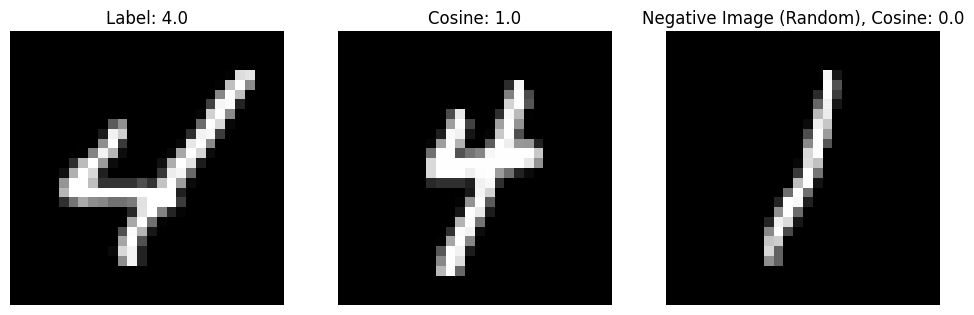

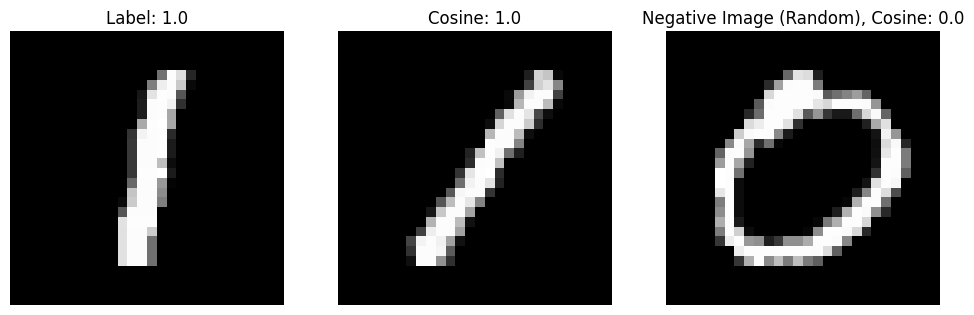

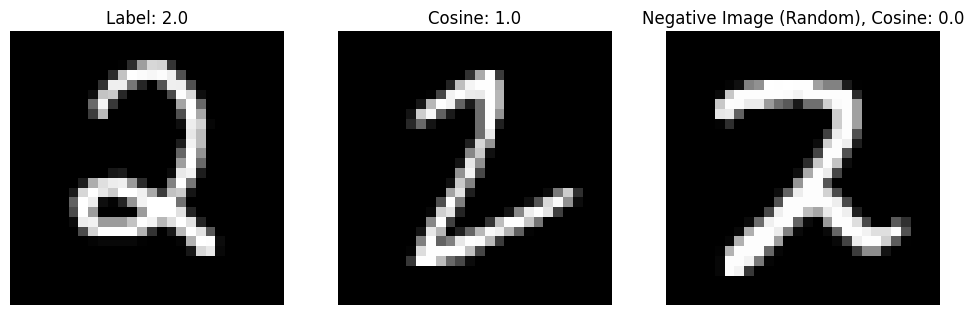

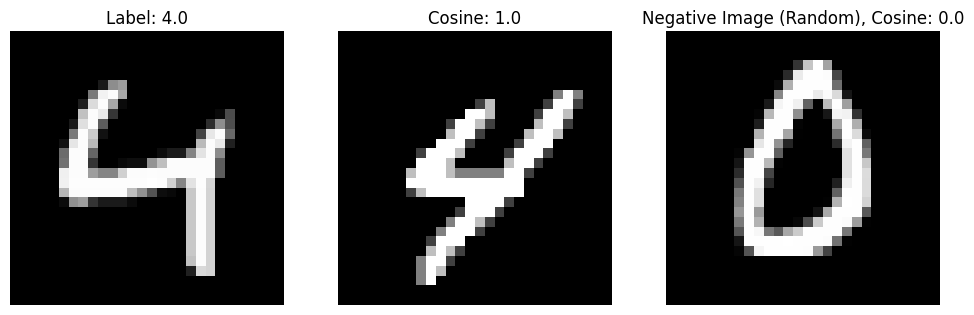

In [145]:
# False: pair of anchor and a second image, True: triplet
CONTRASTIVE = True 
EMBED = 128
BATCH = 128
NUM_SAMPLES = 1000
NUM_CLUSTERS=5
NUM_TENSORS = 5

CLASS_KNOWLEDGE = True
ELASTIC=True
CENTER = False

contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic = ELASTIC
)

# Use k-means++ to initialize cluster centers
centers, indices = kmeans_plusplus(contra_X.numpy(), n_clusters=NUM_TENSORS, random_state=20)
clust_assign = clust_matrix(contra_X, NUM_TENSORS, centers)
centers = update_centers(contra_X, centers, clust_assign, -1)

# Set initial clust_assign in the dataset
contra_dataset.set_clust_assign(clust_assign)
contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)
for i in range(4):
    plot_dataset_sample(contra_dataset, i, contrastive = True)

In [146]:
EPOCHS = 25
net_5_2 = Network()
# define optimizer
optimizer_5_2 = optim.Adam(net_5_2.parameters(), lr=0.00001)
# define loss function
loss_function = ContrastiveLoss()

lrs_5_2 = []
losses_5_2 = []
scheduler = optim.lr_scheduler.StepLR(optimizer_5_2, step_size=40, gamma=0.85)
# torch training loop
for epoch in range(EPOCHS):
    epoch_loss = 0
    batches=0
    print('epoch -', epoch)
    lrs_5_2.append(optimizer_5_2.param_groups[0]['lr'])
    print('learning rate', lrs_5_2[-1])
    for idx, anchor, positive, negative, pos_dis, neg_dis, label in tqdm(contra_train_loader):
        batches+=1
        optimizer_5_2.zero_grad()
        anchor_out = net(anchor)
        positive_out = net(positive)
        negative_out = net(negative)
        loss = loss_function(anchor_out, positive_out, negative_out)
        loss=loss.mean()
        epoch_loss += loss.item()
        loss.backward()
        optimizer_5_2.step()
    
    losses_5_2.append(epoch_loss / batches)
    scheduler.step()
    print('epoch_loss', losses_5_2[-1])

epoch - 0
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3446816634386778
epoch - 1
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3047615569084883
epoch - 2
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.38295138999819756
epoch - 3
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3256442993879318
epoch - 4
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.33958224207162857
epoch - 5
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3075939863920212
epoch - 6
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.29039893206208944
epoch - 7
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.33058593980968
epoch - 8
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.28120532166212797
epoch - 9
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3846626989543438
epoch - 10
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.2644619680941105
epoch - 11
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.32182308845221996
epoch - 12
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.31435687467455864
epoch - 13
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3655606769025326
epoch - 14
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3496763613075018
epoch - 15
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.331594199873507
epoch - 16
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.2501846896484494
epoch - 17
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.2582708057016134
epoch - 18
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.37096712924540043
epoch - 19
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.28299709409475327
epoch - 20
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.2628067028708756
epoch - 21
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.33111103996634483
epoch - 22
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3187834545969963
epoch - 23
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.286478322930634
epoch - 24
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.2525558043271303


In [147]:
# Get the representations
representations_5_2 = get_representations(net_5_2, contra_X)

# Apply K-means clustering on original X
num_clusters = NUM_CLUSTERS
kmeans_original_5_2 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_original_5_2.fit(contra_X)
predictions_original_5_2 = kmeans_original_5_2.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_5_2 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_representations_5_2.fit(representations_5_2)
predictions_representations_5_2 = kmeans_representations_5_2.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_5_2 = adjusted_rand_score(contra_Y, predictions_original_5_2)
ari_representations_5_2 = adjusted_rand_score(contra_Y, predictions_representations_5_2)

print(f'Adjusted Rand Index (ARI) for original X: {ari_original_5_2}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_5_2}')

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7320262845889915
Adjusted Rand Index (ARI) for representations: 0.7494813306877537


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [190]:
CONTRASTIVE,loss_fn,COSINE = experiments.get(3)

ELASTIC=False
CENTER=False
CLASS_KNOWLEDGE = True

contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic=ELASTIC
)

contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)


MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


In [191]:
net_6_2, train_loss_6_2, clust_assign_6_2, embeddings_6_2 = train(contra_X,contra_Y,contra_train_loader, n_tensors=NUM_TENSORS,in_feature=-1,embed=EMBED, contrastive=CONTRASTIVE,epochs=25, lr=0.001,cosine=COSINE,loss_fn=loss_fn)

clust_assign in the beginning:  tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.]])


Training Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.22033944726628452
epoch  1  loss  -185.68065636232495


Epoch 2/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.3223549043235175
epoch  2  loss  -13259.701904296875


Epoch 3/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.4150638818489597
epoch  3  loss  -262919.888671875


Epoch 4/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.42417202055650954
epoch  4  loss  -2154483.1484375


Epoch 5/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.4301220865269028
epoch  5  loss  -11060912.75


Epoch 6/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.44155645086181095
epoch  6  loss  -38801565.25


Epoch 7/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.43876183610177005
epoch  7  loss  -123372363.0


Epoch 8/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.45613867988276635
epoch  8  loss  -330351772.0


Epoch 9/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.45933945630862005
epoch  9  loss  -783069576.0


Epoch 10/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.4603046791265156
epoch  10  loss  -1636706112.0


Epoch 11/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.48168822914539294
epoch  11  loss  -3284110752.0


Epoch 12/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.47166630130224146
epoch  12  loss  -5798327424.0


Epoch 13/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.4932918395880013
epoch  13  loss  -9875909568.0


Epoch 14/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.4946292076502884
epoch  14  loss  -16655312896.0


Epoch 15/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5138307882127854
epoch  15  loss  -27806032896.0


Epoch 16/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5022365138652912
epoch  16  loss  -42272428544.0


Epoch 17/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5272759806864861
epoch  17  loss  -62226262528.0


Epoch 18/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5393341535639574
epoch  18  loss  -94152910848.0


Epoch 19/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5828294212707131
epoch  19  loss  -137551662080.0


Epoch 20/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5588077998841458
epoch  20  loss  -192322191360.0


Epoch 21/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.6182205249334991
epoch  21  loss  -261860061184.0


Epoch 22/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5990025639806351
epoch  22  loss  -361580150784.0


Epoch 23/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.6198560887022553
epoch  23  loss  -499097542656.0


Epoch 24/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.6440833331441935
epoch  24  loss  -689575796736.0


Epoch 25/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.6540446323204626
epoch  25  loss  -893474398208.0
clust_assign in the beginning:  tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.]])


In [192]:
representations_6_2 = embeddings_6_2

# Apply K-means clustering on original X
kmeans_original_6_2 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_original_6_2.fit(contra_X)
predictions_original_6_2 = kmeans_original_6.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_6_2 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_representations_6_2.fit(representations_6_2)
predictions_representations_6_2 = kmeans_representations_6_2.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_6_2 = adjusted_rand_score(contra_Y, predictions_original_6_2)
ari_representations_6_2 = adjusted_rand_score(contra_Y, predictions_representations_6_2)
ari_clust_6_2= adjusted_rand_score(torch.argmax(clust_assign_6_2,axis=0).cpu().detach().numpy(), contra_Y.cpu().detach().numpy())
print(f'Adjusted Rand Index (ARI) for original X: {ari_original_6_2}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_6_2}')
print(f'Adjusted Rand Index (ARI) for clust_assign:{ari_clust_6_2}')


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.003935286234813841
Adjusted Rand Index (ARI) for representations: 0.6728248530255048
Adjusted Rand Index (ARI) for clust_assign:0.6540446323204626


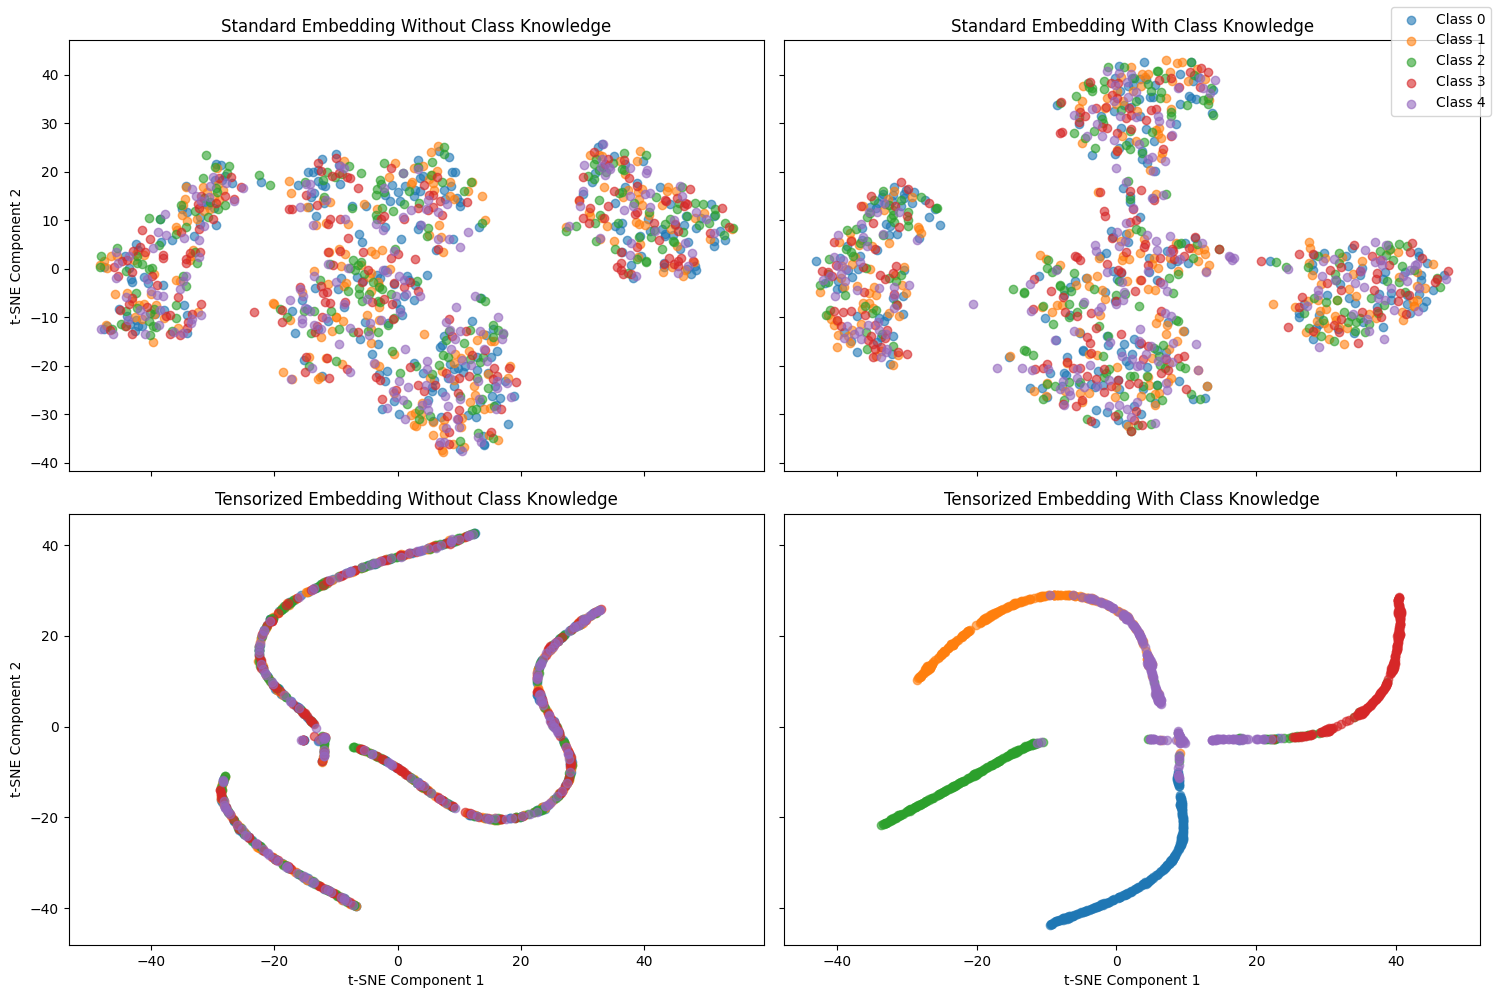

In [177]:
import numpy as np
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt

def save_and_plot_embeddings(embeddings_list, labels, titles, save_dir="saved_embeddings", nrows=2, ncols=2):
    tsne = TSNE(n_components=2, random_state=42)
    
    # Create the directory to save the numpy files if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Create subplots with shared Y-axis within each row and shared X-axis within each column
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10), sharey='row', sharex='col')
    axs = axs.flatten()  # Flatten to easily iterate over

    for i, (embeddings, title) in enumerate(zip(embeddings_list, titles)):
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Save the 2D embeddings as a numpy file
        np.save(os.path.join(save_dir, f"{title.replace(' ', '_')}_2d.npy"), embeddings_2d)
        
        labels_np = labels.cpu().numpy() if hasattr(labels, 'cpu') else labels  # Ensure labels are numpy array
        unique_labels = np.unique(labels_np)
        
        ax = axs[i]
        colors = plt.get_cmap('tab10')  # Use the 'tab10' color palette
        
        for label in unique_labels:
            idx = labels_np == label
            ax.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Class {label}', alpha=0.6, c=[colors(label)])
        
        ax.set_title(title)
        if i % ncols == 0:  # Set Y-axis label for the first column in each row
            ax.set_ylabel('t-SNE Component 2')
        if i // ncols == (nrows - 1):  # Set X-axis label for the last row
            ax.set_xlabel('t-SNE Component 1')
        
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

# Representations and corresponding titles
embeddings_list = [representations_5, representations_5_2, representations_6, representations_6_2]
titles = ["Standard Embedding Without Class Knowledge", "Standard Embedding With Class Knowledge",
          "Tensorized Embedding Without Class Knowledge", "Tensorized Embedding With Class Knowledge"]

# Save and plot the embeddings
save_and_plot_embeddings(embeddings_list, contra_Y, titles)


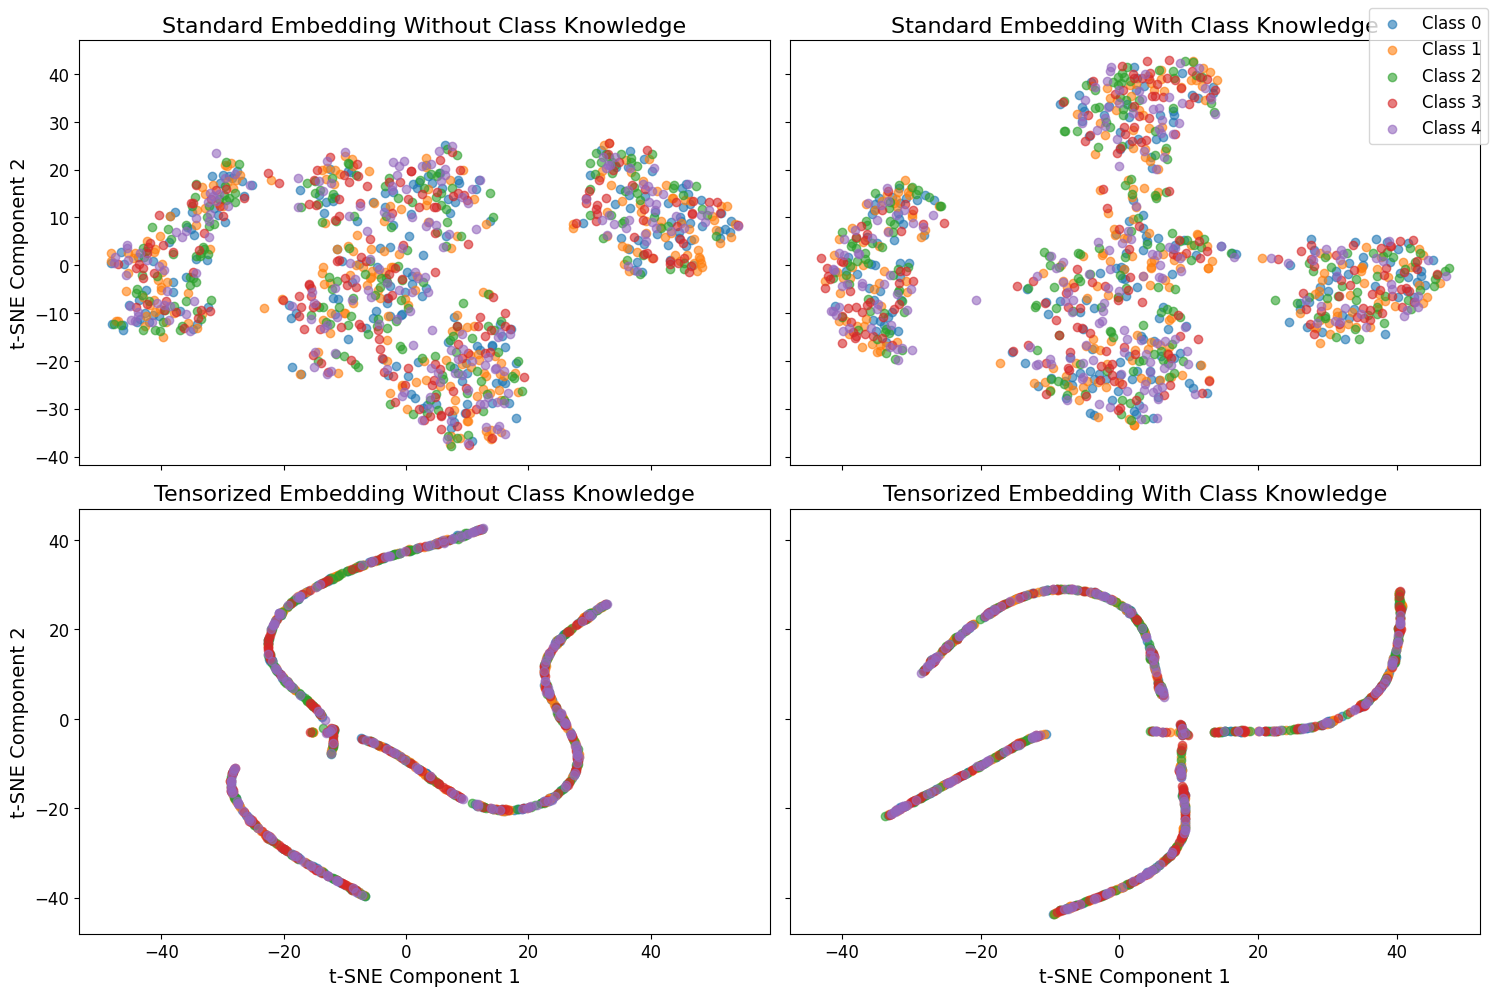

In [188]:
import numpy as np
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt

def save_and_plot_embeddings(embeddings_list, labels, titles, save_dir="saved_embeddings", nrows=2, ncols=2):
    tsne = TSNE(n_components=2, random_state=42)
    
    # Create the directory to save the numpy files if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Create subplots with shared Y-axis within each row and shared X-axis within each column
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10), sharey='row', sharex='col')
    axs = axs.flatten()  # Flatten to easily iterate over

    # Set font sizes
    title_fontsize = 16
    label_fontsize = 14
    tick_fontsize = 12
    legend_fontsize = 12

    for i, (embeddings, title) in enumerate(zip(embeddings_list, titles)):
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Save the 2D embeddings as a numpy file
        np.save(os.path.join(save_dir, f"{title.replace(' ', '_')}_2d.npy"), embeddings_2d)
        
        labels_np = labels.cpu().numpy() if hasattr(labels, 'cpu') else labels  # Ensure labels are numpy array
        unique_labels = np.unique(labels_np)
        
        ax = axs[i]
        colors = plt.get_cmap('tab10')  # Use the 'tab10' color palette
        
        for label in unique_labels:
            idx = labels_np == label
            ax.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Class {label}', alpha=0.6, c=[colors(label)])
        
        ax.set_title(title, fontsize=title_fontsize)
        if i % ncols == 0:  # Set Y-axis label for the first column in each row
            ax.set_ylabel('t-SNE Component 2', fontsize=label_fontsize)
        if i // ncols == (nrows - 1):  # Set X-axis label for the last row
            ax.set_xlabel('t-SNE Component 1', fontsize=label_fontsize)
        
        # Set tick parameters for better readability
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=legend_fontsize)
    plt.tight_layout()
    plt.show()

# Representations and corresponding titles
embeddings_list = [representations_5, representations_5_2, representations_6, representations_6_2]
titles = ["Standard Embedding Without Class Knowledge", "Standard Embedding With Class Knowledge",
          "Tensorized Embedding Without Class Knowledge", "Tensorized Embedding With Class Knowledge"]

# Save and plot the embeddings
save_and_plot_embeddings(embeddings_list, contra_Y, titles)


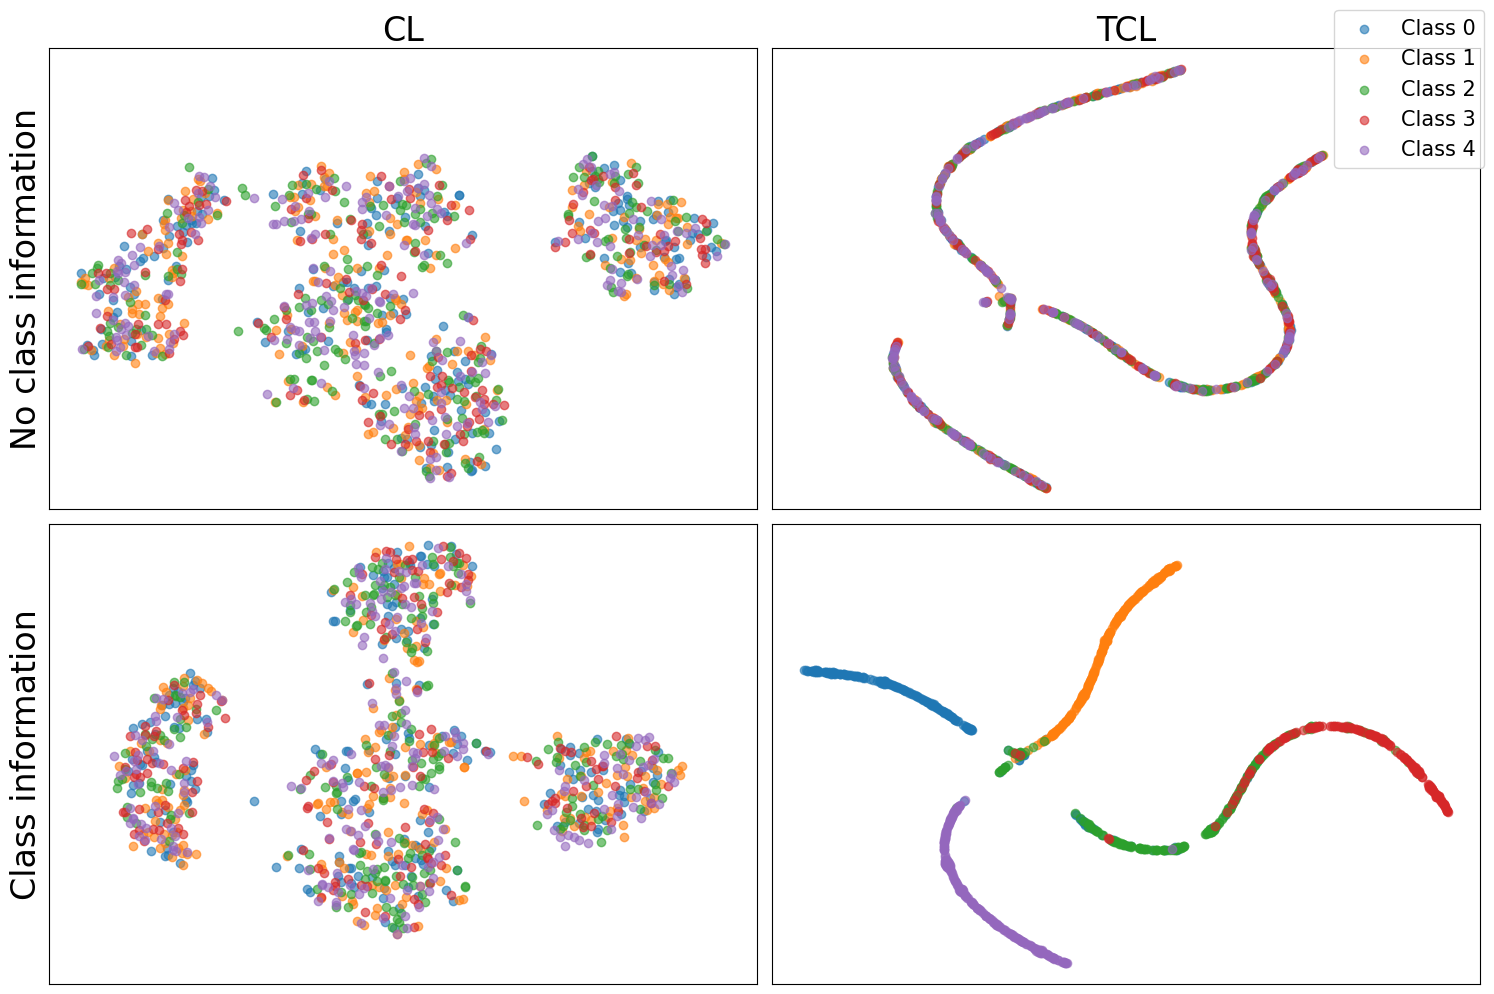

In [199]:
import numpy as np
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt

def save_and_plot_embeddings(embeddings_list, labels, titles, save_dir="saved_embeddings", nrows=2, ncols=2):
    tsne = TSNE(n_components=2, random_state=42)
    
    # Create the directory to save the numpy files if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Create subplots with shared Y-axis within each row and shared X-axis within each column
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10), sharey='row', sharex='col')
    axs = axs.flatten()  # Flatten to easily iterate over

    # Set font sizes (increased as per your instruction)
    title_fontsize = 24
    label_fontsize = 24
    tick_fontsize = 14
    legend_fontsize = 15

    # Adjust titles and labels according to the new layout
    row_titles = ['No class information', 'Class information']
    col_titles = ['CL', 'TCL']

    for i, (embeddings, title) in enumerate(zip(embeddings_list, titles)):
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Save the 2D embeddings as a numpy file
        np.save(os.path.join(save_dir, f"{title.replace(' ', '_')}_2d.npy"), embeddings_2d)
        
        labels_np = labels.cpu().numpy() if hasattr(labels, 'cpu') else labels  # Ensure labels are numpy array
        unique_labels = np.unique(labels_np)
        
        ax = axs[i]
        colors = plt.get_cmap('tab10')  # Use the 'tab10' color palette
        
        for label in unique_labels:
            idx = labels_np == label
            ax.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Class {label}', alpha=0.6, c=[colors(label)])
        
        if i // ncols == 0:  # Set titles only for the first row
            ax.set_title(col_titles[i % ncols], fontsize=title_fontsize)
        if i % ncols == 0:  # Set Y-axis label for the first column in each row
            ax.set_ylabel(row_titles[i // ncols], fontsize=label_fontsize)
        
        # Remove ticks and axis numbers
        ax.tick_params(axis='both', which='both', labelsize=0, length=0)
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust legend placement and fontsize
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=legend_fontsize)
    
    plt.tight_layout()
    plt.show()

# Representations and corresponding titles
embeddings_list = [representations_5, representations_6, representations_5_2, representations_6_2]
titles = ["Standard Embedding Without Class Knowledge", "Standard Embedding With Class Knowledge",
          "Tensorized Embedding Without Class Knowledge", "Tensorized Embedding With Class Knowledge"]

# Save and plot the embeddings
save_and_plot_embeddings(embeddings_list, contra_Y, titles)

